In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import pickle
import matplotlib.pyplot as plt
import os
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
import torch.nn.functional as F
from early_stopping_pytorch import EarlyStopping

In [2]:
# Check PyTorch version
print("PyTorch Version: ", torch.__version__)
# Check GPU
if torch.cuda.is_available():
    print("GPU Device Name: ", torch.cuda.get_device_name(0))
else:
    print("No GPU available.")

PyTorch Version:  2.5.1+cu118
GPU Device Name:  Quadro RTX 8000


In [3]:
class SequenceLabelingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.02):
        super(SequenceLabelingRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True,bias=True) #Bidirectional LSTM
        self.fc = nn.Linear(hidden_size*2, output_size) #*2 because bidirectional

    def forward(self, x):
        out, _ = self.rnn(x)  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        out = self.fc(out) #Output for every timestep
        return out


class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.02):
        super(AttentionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.attention = nn.Linear(hidden_size * 2, 1) # Attention layer
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size*2)
        attention_weights = F.softmax(self.attention(lstm_out), dim=1) # (batch_size, seq_len, 1)
        attended_output = torch.sum(attention_weights * lstm_out, dim=1) # (batch_size, hidden_size*2)
        out = self.fc(attended_output)
        return out


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.02):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding) #Removes padding
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()
        print(f"TemporalBlock: n_inputs={n_inputs}, n_outputs={n_outputs}")
    
    def init_weights(self):
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        if self.downsample is not None:
            nn.init.kaiming_normal_(self.downsample.weight, mode='fan_out', nonlinearity='relu')
    
    # def init_weights(self):
    #     self.conv1.weight.data.normal_(0, 0.01)
    #     self.conv2.weight.data.normal_(0, 0.01)
    #     if self.downsample is not None:
    #         self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size - 1) * dilation_size, dropout=dropout)]
        
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 2)  # Output layer for binary classification

    def forward(self, x):
        # Input: [batch_size, input_size, sequence_length]
        x = self.network(x)  # Shape: [batch_size, num_channels[-1], sequence_length]
        x = x.transpose(1, 2)  # Transpose to [batch_size, sequence_length, num_channels[-1]]
        x = self.fc(x)  # Apply FC layer to each timestep
        return x



In [4]:
# Load data
with open('/scratch/da3245/datasets/timeseries_voltage/pre_split_overlap50.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [5]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (25418, 500)
y_train shape: (25418, 500)
X_val shape: (5373, 500)
y_val shape: (5373, 500)
X_test shape: (5373, 500)
y_test shape: (5373, 500)


In [6]:
# Convert back to tensors for DataLoader
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Add channel dimension
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)  
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_val_loss = float('inf')
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 2 #Binary classification for each timestep
dropout_rate = 0.05
lr=0.001

### Sequential

In [8]:
model = SequenceLabelingRNN(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(patience=5, verbose=True) #https://github.com/Bjarten/early-stopping-pytorch
from torchinfo import summary
print(summary(model, input_size=(32,1)) )

Layer (type:depth-idx)                   Output Shape              Param #
SequenceLabelingRNN                      [32, 2]                   --
├─LSTM: 1-1                              [32, 128]                 133,632
├─Linear: 1-2                            [32, 2]                   258
Total params: 133,890
Trainable params: 133,890
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 547.36
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.54
Estimated Total Size (MB): 0.57


In [9]:
# Training loop
num_epochs = 30
val_interval = 1
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, output_size), labels.view(-1)) #Reshape for loss calculation
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses.append(loss.item())
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 2), labels.view(-1))
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
        val_losses.append(val_loss)
    
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
            print("Saving best model...")
        else:
            early_stopping(val_loss, model)
    
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

Epoch [1/30], Loss: 0.0055
Epoch [1/30], Train Loss: 0.0039, Val Loss: 0.0055
Saving best model...
Epoch [2/30], Loss: 0.0164
Epoch [2/30], Train Loss: 0.0037, Val Loss: 0.0049
Saving best model...
Epoch [3/30], Loss: 0.0098
Epoch [3/30], Train Loss: 0.0038, Val Loss: 0.0046
Saving best model...
Epoch [4/30], Loss: 0.0063
Epoch [4/30], Train Loss: 0.0027, Val Loss: 0.0043
Saving best model...
Epoch [5/30], Loss: 0.0034
Epoch [5/30], Train Loss: 0.0036, Val Loss: 0.0044
Validation loss decreased (inf --> 0.004355).  Saving model ...
Epoch [6/30], Loss: 0.0069
Epoch [6/30], Train Loss: 0.0028, Val Loss: 0.0043
Saving best model...
Epoch [7/30], Loss: 0.0031
Epoch [7/30], Train Loss: 0.0022, Val Loss: 0.0037
Saving best model...
Epoch [8/30], Loss: 0.0085
Epoch [8/30], Train Loss: 0.0026, Val Loss: 0.0037
Validation loss decreased (0.004355 --> 0.003733).  Saving model ...
Epoch [9/30], Loss: 0.0042
Epoch [9/30], Train Loss: 0.0025, Val Loss: 0.0035
Saving best model...
Epoch [10/30], Los

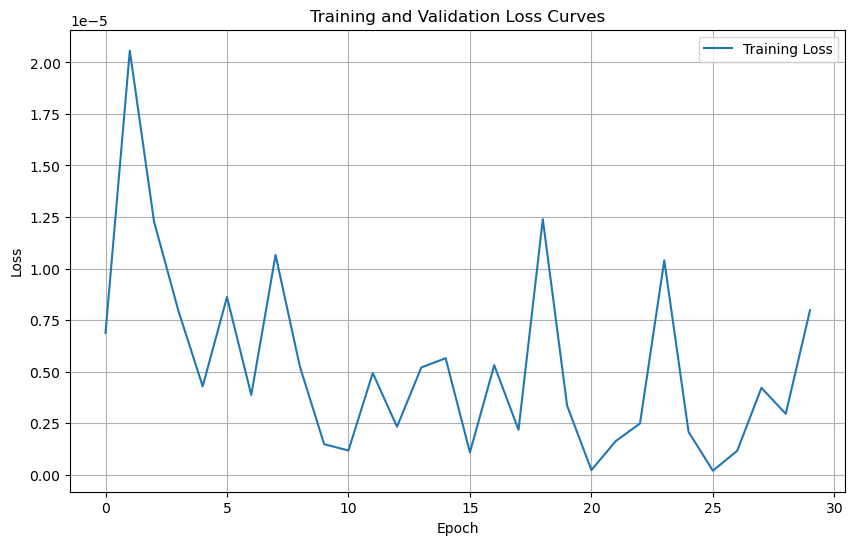

In [10]:
# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot([loss/len(train_loader) for loss in train_losses], label='Training Loss')
#plt.plot(train_losses, label='Training Loss')
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

#### Training vs Test

In [22]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, device, num_epochs=30, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        num_train_batches = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 2), labels.view(-1))
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            num_train_batches += 1

        train_losses.append(epoch_train_loss / num_train_batches)

        model.eval()
        epoch_val_loss = 0.0
        num_val_batches = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 2), labels.view(-1))
                epoch_val_loss += loss.item()
                num_val_batches += 1

        val_losses.append(epoch_val_loss / num_val_batches)


    precision, recall, f1, auc, accuracy,best_f1,best_thresh,test_loss = evaluate_model(model, test_loader, device)

    return precision, recall, f1, auc, accuracy,best_f1,best_thresh,test_loss


train_sizes = np.linspace(0.1, 1.0, 10)  # 10 steps from 10% to 100% of training data
f1_scores = []
all_metrics={}
for train_size in train_sizes:
    num_train_samples = int(len(X_train) * train_size)
    train_subset_indices = np.random.choice(len(X_train), num_train_samples, replace=False)
    X_train_subset = X_train[train_subset_indices]
    y_train_subset = y_train[train_subset_indices]

    train_subset_dataset = TensorDataset(X_train_subset, y_train_subset)
    train_subset_loader = DataLoader(train_subset_dataset, batch_size=32, shuffle=True)

    #Train and evaluate the model
    model =  SequenceLabelingRNN(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
    precision, recall, f1, auc, accuracy,best_f1,best_thresh,test_loss = train_and_evaluate(model, train_subset_loader, val_loader, test_loader, device)
    f1_scores.append(f1)
    all_metrics[train_size]=[precision, recall, f1, auc, accuracy,best_f1,best_thresh,test_loss ]

Test Loss: 0.0044
Optimal Threshold: 0.4267
Best F1-Score at Optimal Threshold: 0.8341
Test Loss: 0.0039
Optimal Threshold: 0.4409
Best F1-Score at Optimal Threshold: 0.8541
Test Loss: 0.0032
Optimal Threshold: 0.5094
Best F1-Score at Optimal Threshold: 0.8797
Test Loss: 0.0037
Optimal Threshold: 0.3652
Best F1-Score at Optimal Threshold: 0.8661
Test Loss: 0.0031
Optimal Threshold: 0.3854
Best F1-Score at Optimal Threshold: 0.8804
Test Loss: 0.0029
Optimal Threshold: 0.3292
Best F1-Score at Optimal Threshold: 0.8961
Test Loss: 0.0025
Optimal Threshold: 0.5213
Best F1-Score at Optimal Threshold: 0.9053
Test Loss: 0.0026
Optimal Threshold: 0.5474
Best F1-Score at Optimal Threshold: 0.8970
Test Loss: 0.0028
Optimal Threshold: 0.2919
Best F1-Score at Optimal Threshold: 0.9001
Test Loss: 0.0027
Optimal Threshold: 0.6222
Best F1-Score at Optimal Threshold: 0.9027


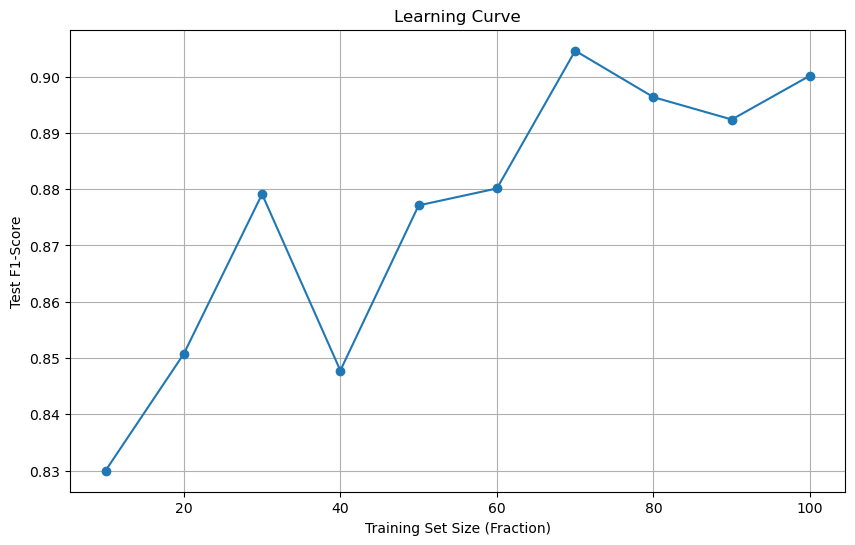

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes*100, f1_scores, marker='o')
plt.xlabel('Training Set Size (Fraction)')
plt.ylabel('Test F1-Score')
plt.title('Learning Curve')
plt.grid(True)
plt.savefig('TestvsTrainingSize.png', dpi=400)
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes*100, f1_scores, marker='o')
plt.xlabel('Training Set Size (Fraction)')
plt.ylabel('Test F1-Score')
plt.title('Learning Curve')
plt.grid(True)
plt.show()

### Attention

In [ ]:
#model = SequenceLabelingRNN(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
model = AttentionLSTM(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels[:,0])
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

### TCN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 1
#num_channels = [32, 64, 128]
num_channels = [32, 64, 128, 256]
kernel_size = 3
dropout = 0.002

model = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)
early_stopping = EarlyStopping(patience=10, verbose=True) #https://github.com/Bjarten/early-stopping-pytorch

#from torchinfo import summary
#print(summary(model, input_size=(32,1,200))) 

In [ ]:
# Training loop
num_epochs = 50
val_interval = 1
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device).permute(0,2,1)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1,2), labels.view(-1))
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses.append(loss.item())
 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device).permute(0,2,1)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 2), labels.view(-1))
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
            print("Saving best model...")
        else:
            early_stopping(val_loss, model)
    
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

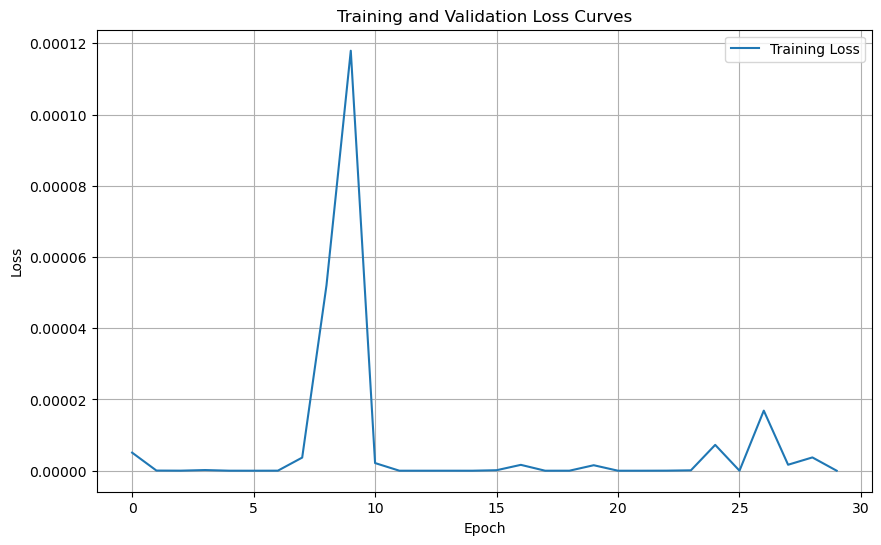

In [17]:
# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot([loss/len(train_loader) for loss in train_losses], label='Training Loss')
#plt.plot(train_losses, label='Training Loss')
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

### Visualization of Architecture

In [9]:
from torchviz import make_dot
import torchviz

dummy_input = torch.randn(1, 200, 1).to(device)  
dummy_input = dummy_input
output = model(dummy_input)


dot = torchviz.make_dot(
        output, 
        params=dict(model.named_parameters()),
        show_attrs=False,  # Hide node attributes
        show_saved=False   # Hide saved tensors
    )
dot.render("TemporalConvNet", format="png")  


'TemporalConvNet.png'

### Evaluation

In [10]:
from sklearn.metrics import precision_recall_curve

def best_thresh_model(model, data_loader, device):
    """Evaluates the model and computes various metrics."""
    model.eval()
    all_true_labels = []
    all_predicted_labels = []
    all_probabilities = []
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs.view(-1, 2), labels.view(-1))
            test_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=2) #Softmax to get probabilities
            # threshold = 0.5325 # Example: Lower threshold
            # predicted = (probabilities[:, :, 1] > threshold).long()
            _, predicted = torch.max(outputs.data, 2)

            all_true_labels.extend(labels.view(-1).cpu().numpy())
            all_predicted_labels.extend(predicted.view(-1).cpu().numpy())
            all_probabilities.extend(probabilities.view(-1,2).cpu().numpy())
            total += labels.view(-1).size(0)
            correct += (predicted.view(-1) == labels.view(-1)).sum().item()
    


    probabilities_positive_class = np.array(all_probabilities)[:, 1]  # Probability of the positive class
    precision_curve, recall_curve, thresholds = precision_recall_curve(all_true_labels, probabilities_positive_class)
    f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)  # F1 for each threshold
    best_threshold = thresholds[np.argmax(f1_scores)]  # Optimal threshold
    best_f1_score = np.max(f1_scores)

    print(f"Optimal Threshold: {best_threshold:.4f}")
    print(f"Best F1-Score at Optimal Threshold: {best_f1_score:.4f}")
    
    return best_f1_score,best_threshold
best_f1_score,best_thresh=best_thresh_model(model, test_loader, device)
print(best_f1_score,best_thresh)

Optimal Threshold: 0.5757
Best F1-Score at Optimal Threshold: 0.9011
0.9010558172626537 0.5757361


In [11]:
from sklearn.metrics import precision_recall_curve

def evaluate_model(model, data_loader, device):
    """Evaluates the model and computes various metrics."""
    model.eval()
    all_true_labels = []
    all_predicted_labels = []
    all_probabilities = []
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #outputs = model(inputs.permute(0,2,1))
            loss = criterion(outputs.view(-1, 2), labels.view(-1))
            test_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=2) #Softmax to get probabilities
            threshold = 0.4951# Example: Lower threshold
            predicted = (probabilities[:, :, 1] > threshold).long()
            #_, predicted = torch.max(outputs.data, 2)

            all_true_labels.extend(labels.view(-1).cpu().numpy())
            all_predicted_labels.extend(predicted.view(-1).cpu().numpy())
            all_probabilities.extend(probabilities.view(-1,2).cpu().numpy())
            total += labels.view(-1).size(0)
            correct += (predicted.view(-1) == labels.view(-1)).sum().item()
    
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    # Calculate metrics
    accuracy=100 * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_predicted_labels, average="binary", zero_division=0
    )
    try:
        auc = roc_auc_score(all_true_labels, np.array(all_probabilities)[:, 1]) #Calculate AUC
    except ValueError:
        auc = np.nan
        print("Only one class present in y_true. ROC AUC score is not defined in that case.")

    probabilities_positive_class = np.array(all_probabilities)[:, 1]  # Probability of the positive class
    precision_curve, recall_curve, thresholds = precision_recall_curve(all_true_labels, probabilities_positive_class)
    f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)  # F1 for each threshold
    best_threshold = thresholds[np.argmax(f1_scores)]  # Optimal threshold
    best_f1_score = np.max(f1_scores)

    print(f"Optimal Threshold: {best_threshold:.4f}")
    print(f"Best F1-Score at Optimal Threshold: {best_f1_score:.4f}")
    
    return precision, recall, f1, auc, accuracy,best_f1_score,best_threshold,test_loss, all_predicted_labels,all_probabilities

In [12]:
# Example usage: Evaluate the model on the test set
precision, recall, f1, auc, accuracy,best_f1,best_thresh,test_loss,predicted,probabilities= evaluate_model(model, test_loader, device)
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Test Loss: 0.0026
Optimal Threshold: 0.5757
Best F1-Score at Optimal Threshold: 0.9011
Accuracy of the model on the test set: 99.89%
Precision: 0.8868
Recall: 0.9132
F1-score: 0.8998
AUC: 0.9998


In [ ]:
model_name='LSTM 50 overlap window 500'
with open('results.txt','a') as f:
    f.write(f'Model Name:{model_name}')
    f.write(f'\n{"-"*32}\n')
    f.write(f'Accuracy: {accuracy:.2f}%\n')
    f.write(f'Precision: {precision:.4f}\n')
    f.write(f'Recall: {recall:.4f}\n')
    f.write(f'F1-score: {f1:.4f}\n')
    f.write(f'AUC: {auc:.4f}\n')
    f.write(f'Best F1: {best_f1:.4f}\n')
    f.write(f'Best Threshold: {best_thresh:.4f}\n')
    f.write(f'Test Loss: {test_loss:.4f}\n')
    f.write(f'{"-"*32}\n')

In [28]:
def visualize_roc_pr(model, test_loader, device):
    model.eval()
    all_true_labels = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=2)  # Get probabilities
            
            all_true_labels.extend(labels.cpu().numpy().flatten()) #Flatten the labels
            all_probabilities.extend(probabilities[:, :, 1].cpu().numpy().flatten()) #Flatten the probabilities of the positive class
    y_test_viz = np.array(all_true_labels)
    y_score = np.array(all_probabilities)
    
    fpr, tpr, _ = roc_curve(y_test_viz, y_score)
    roc_auc = auc(fpr, tpr)

    # Calculate the Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test_viz, y_score)
    pr_auc = average_precision_score(y_test_viz, y_score)

    
    # Plot the ROC curve
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.savefig('ROCcurve.png',dpi=400)
    plt.legend(loc="lower right")
    
    # Plot the Precision-Recall curve
    plt.subplot(1,2,2)
    plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.savefig('PrecisionRecallCurve.png',dpi=400)
    plt.show()
     
    return y_test_viz,y_score

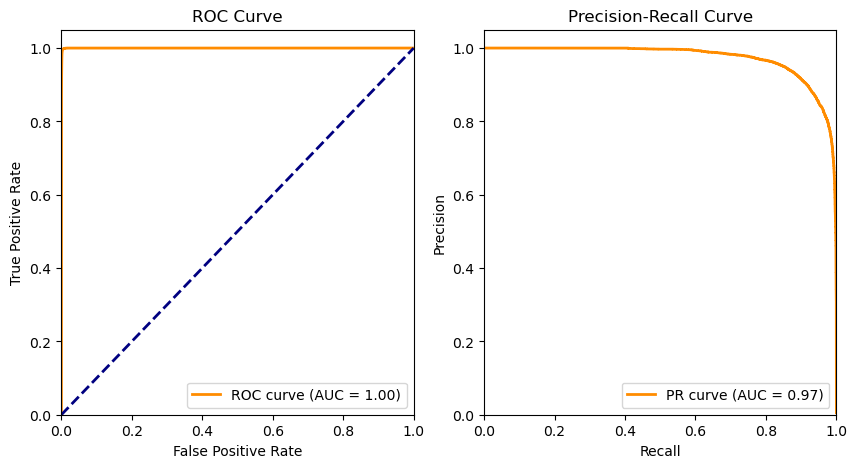

In [29]:
y_test_viz,y_score=visualize_roc_pr(model, test_loader, device)

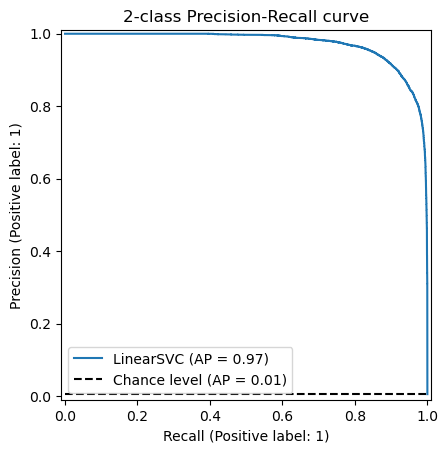

In [30]:
display = PrecisionRecallDisplay.from_predictions(
    y_test_viz, y_score, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

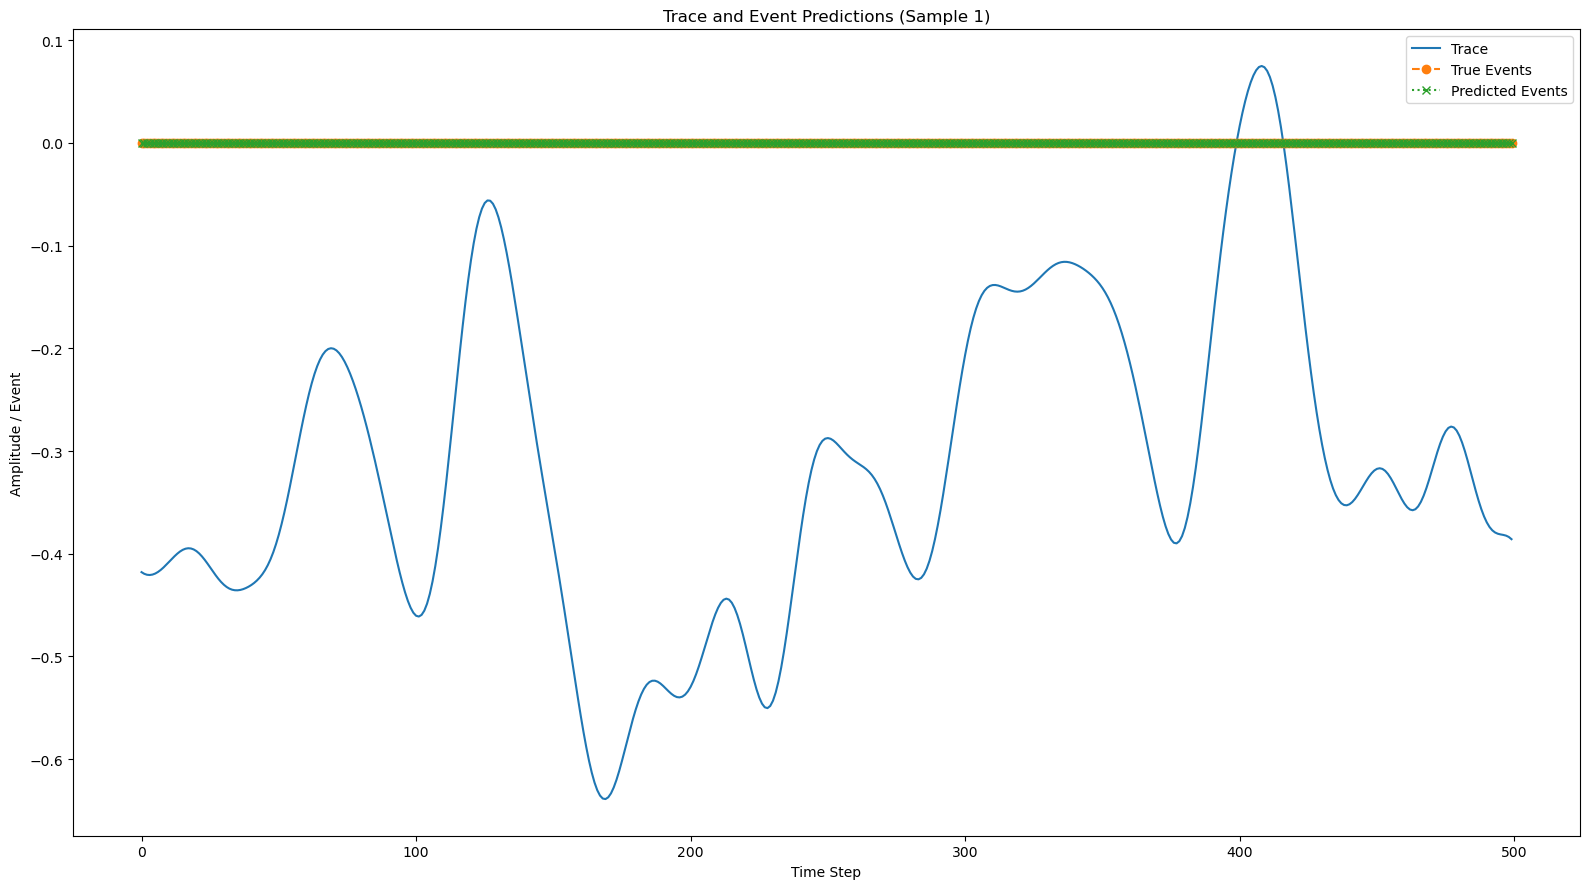

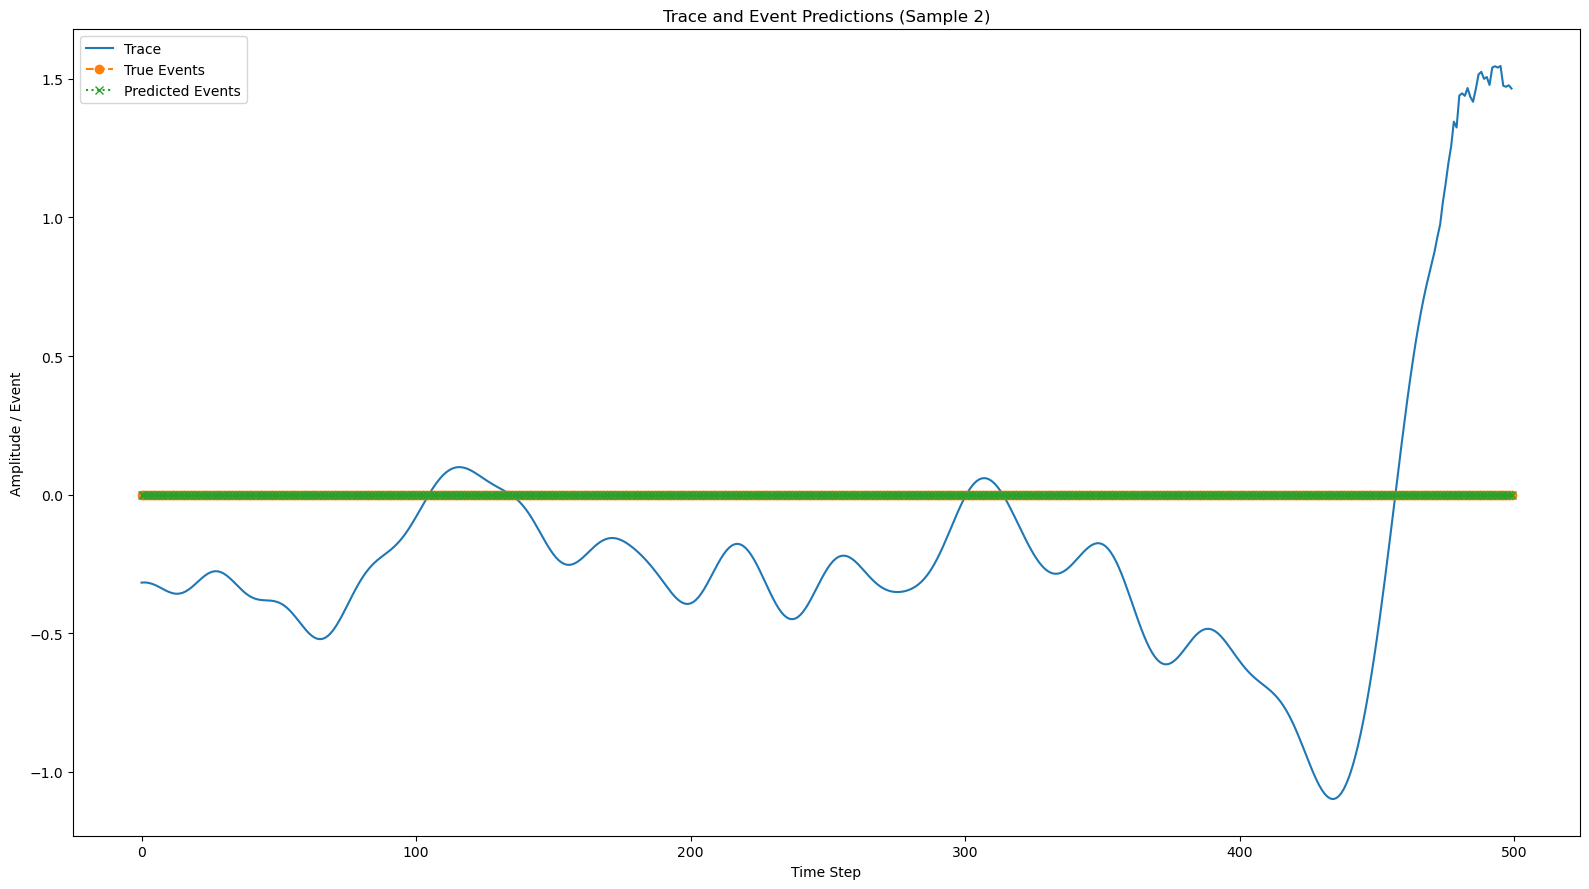

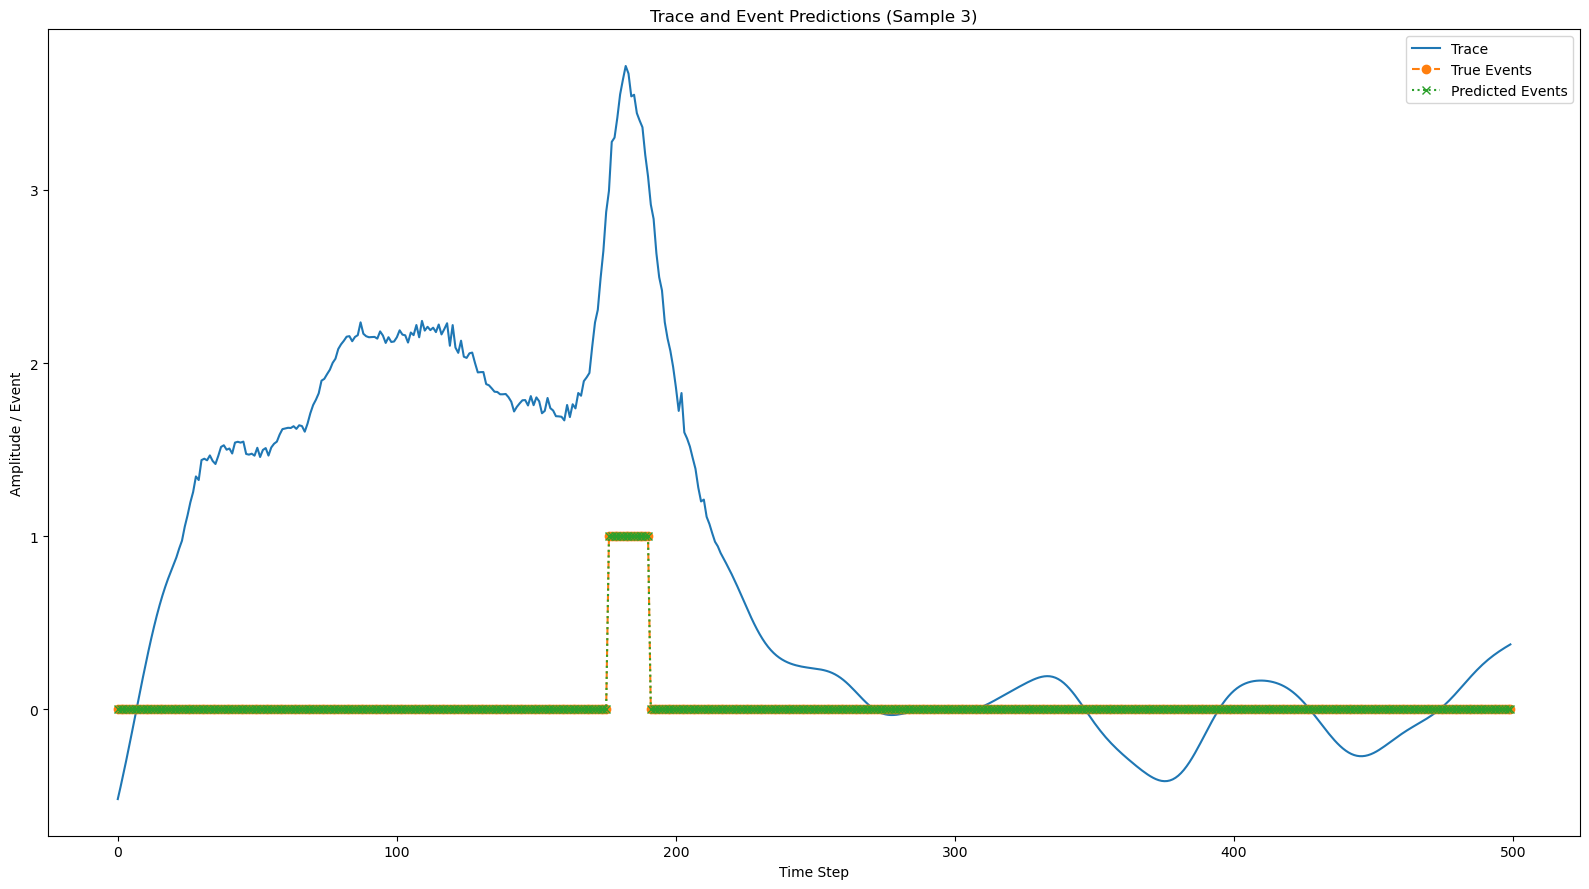

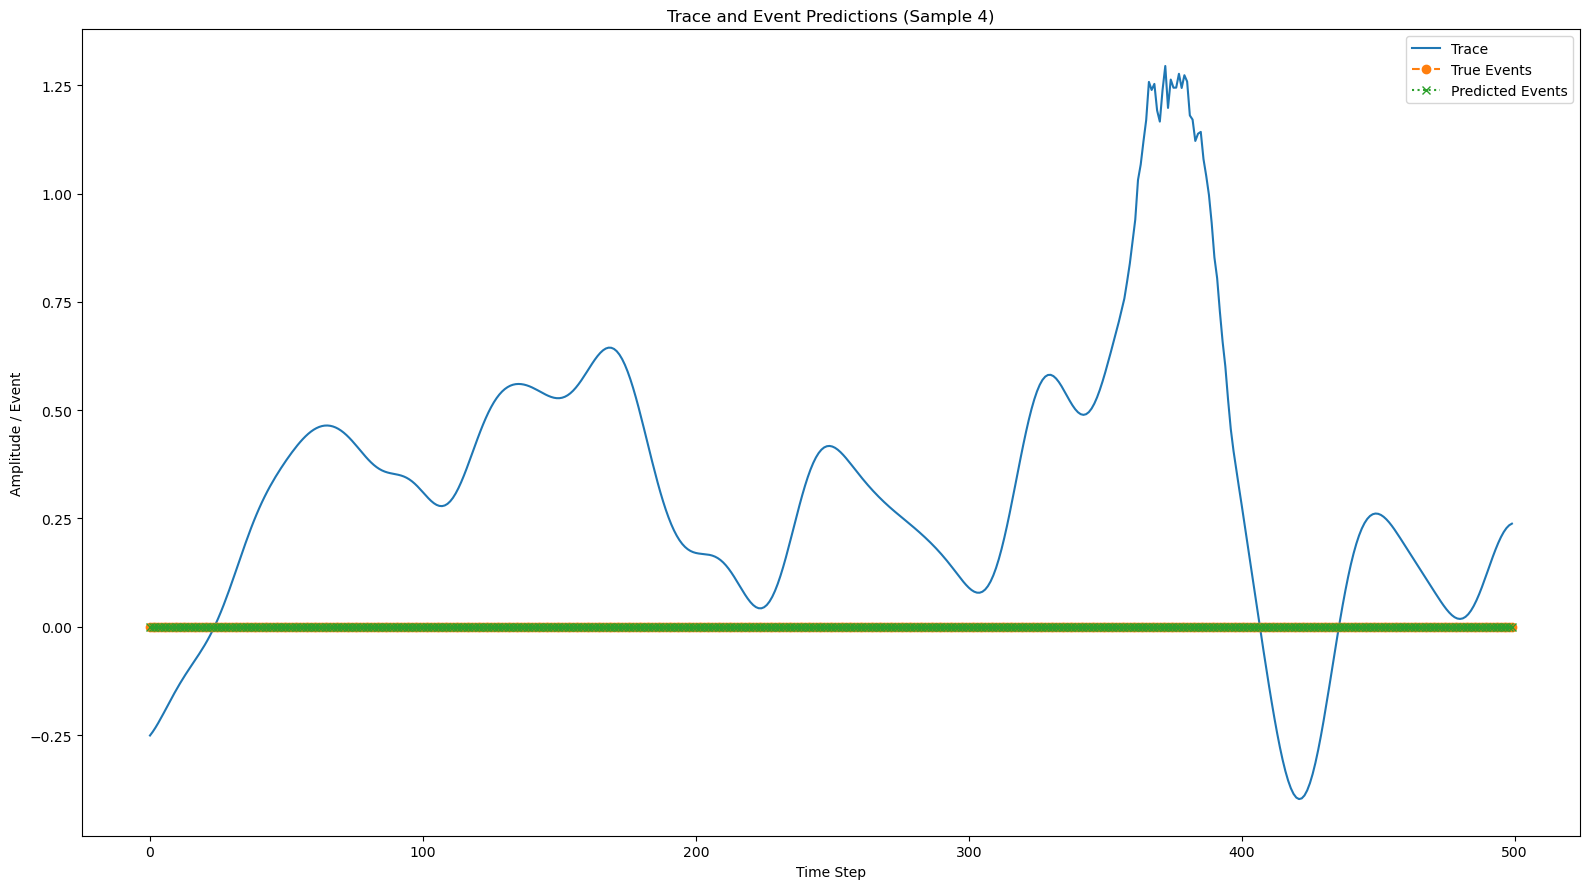

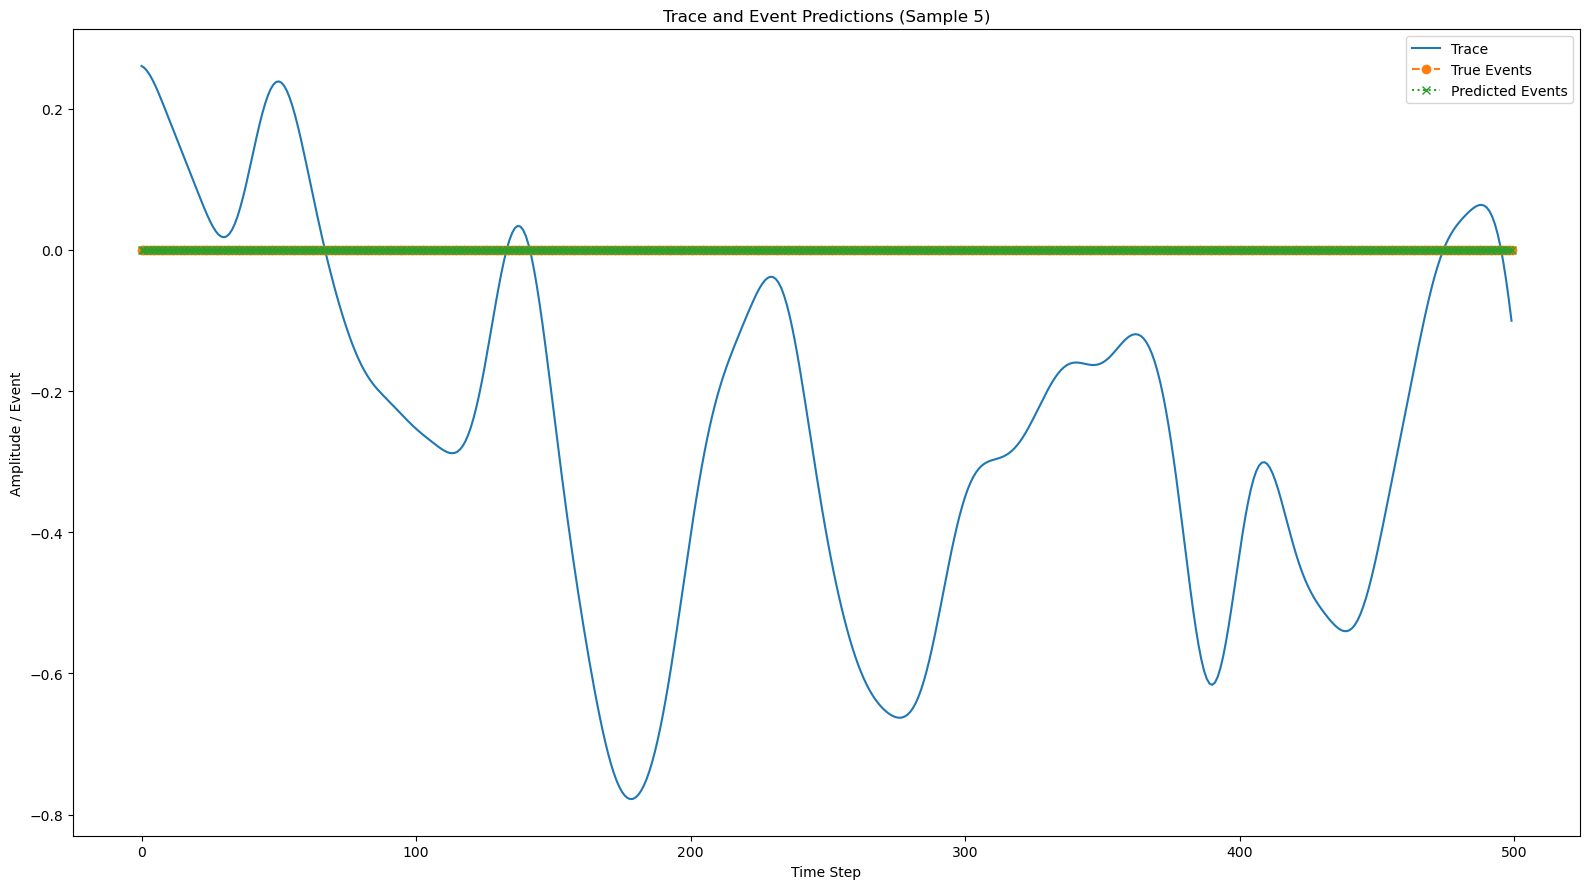

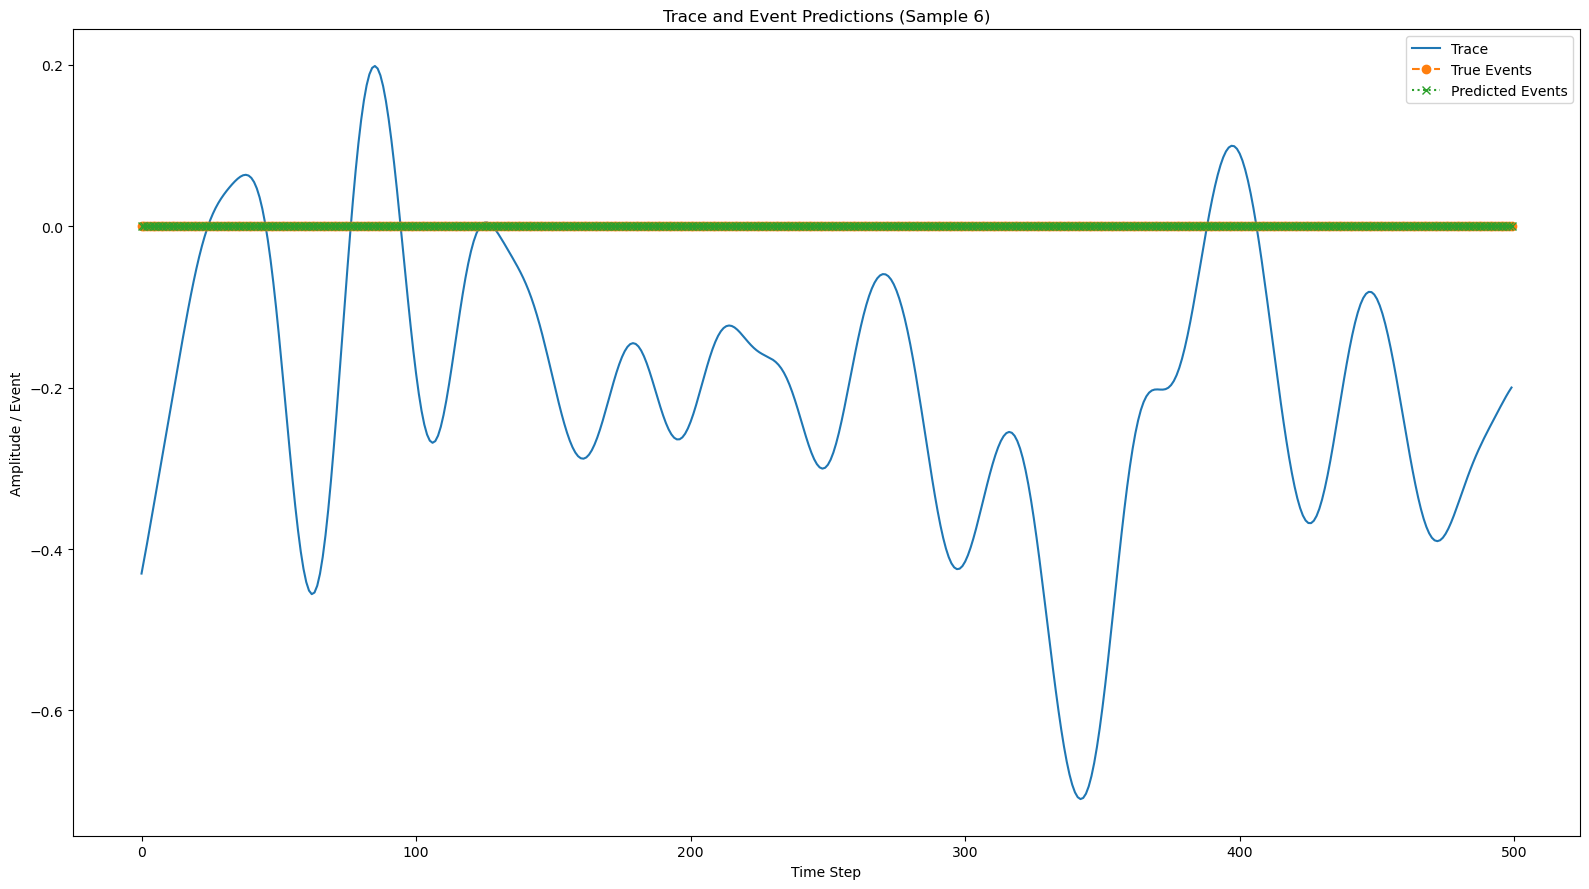

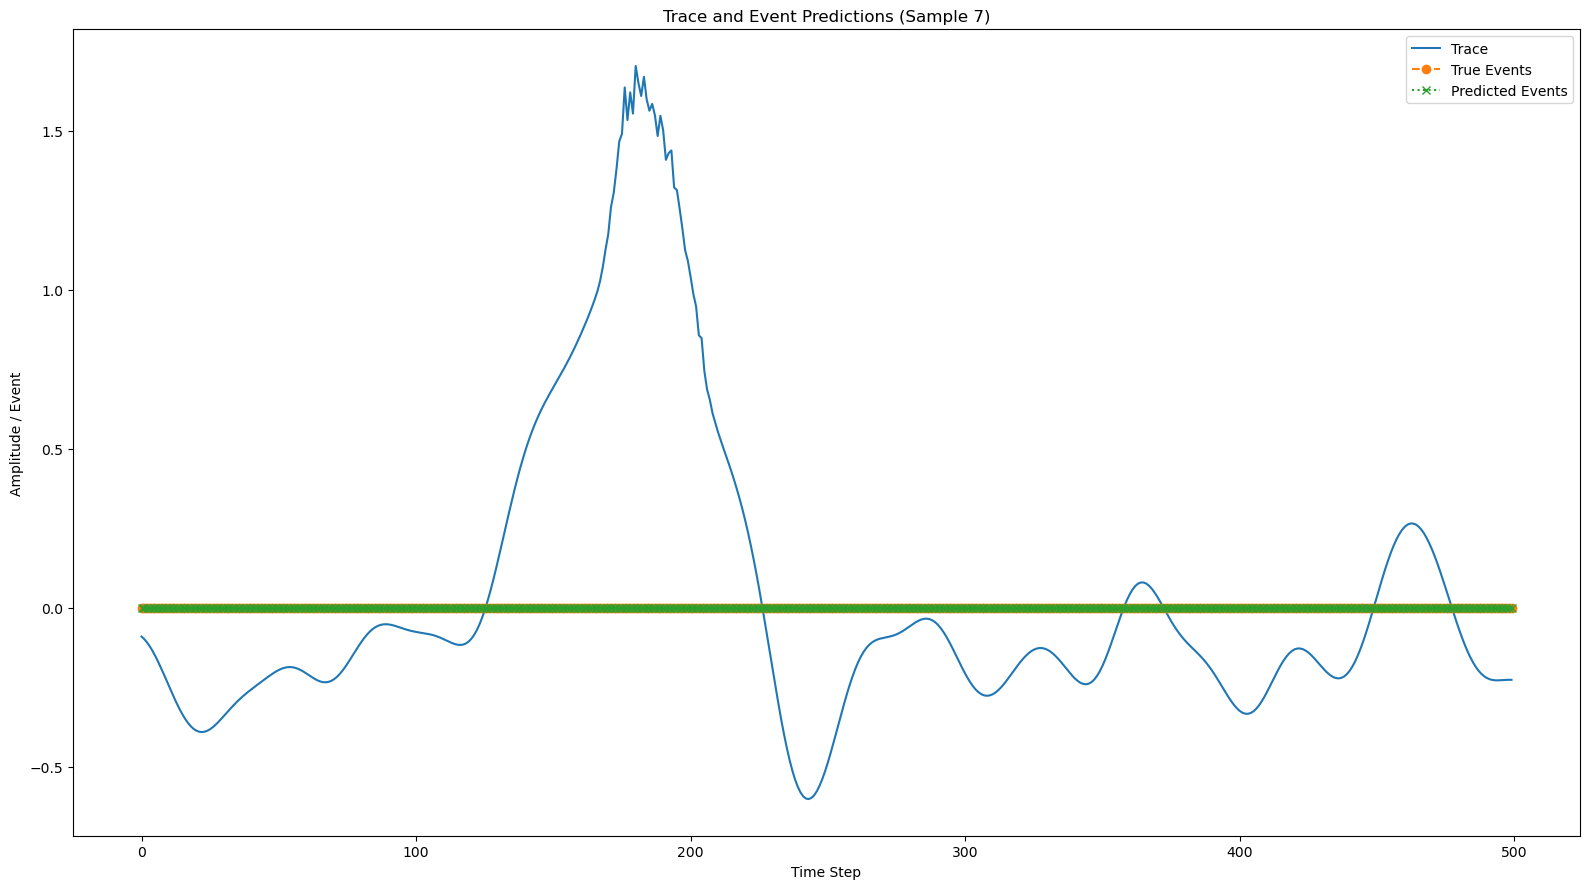

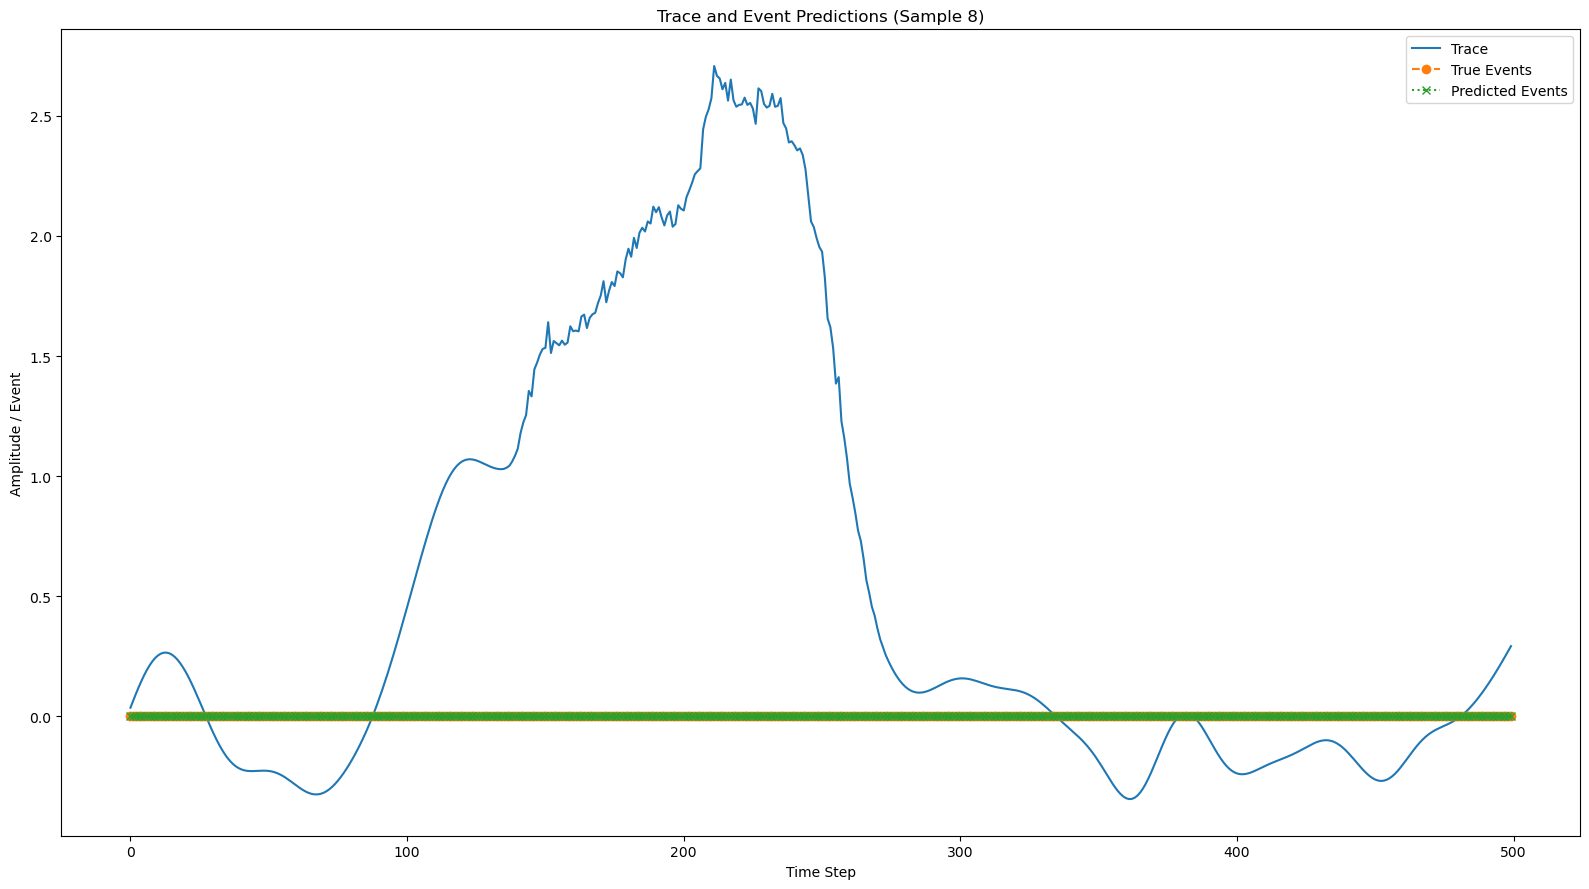

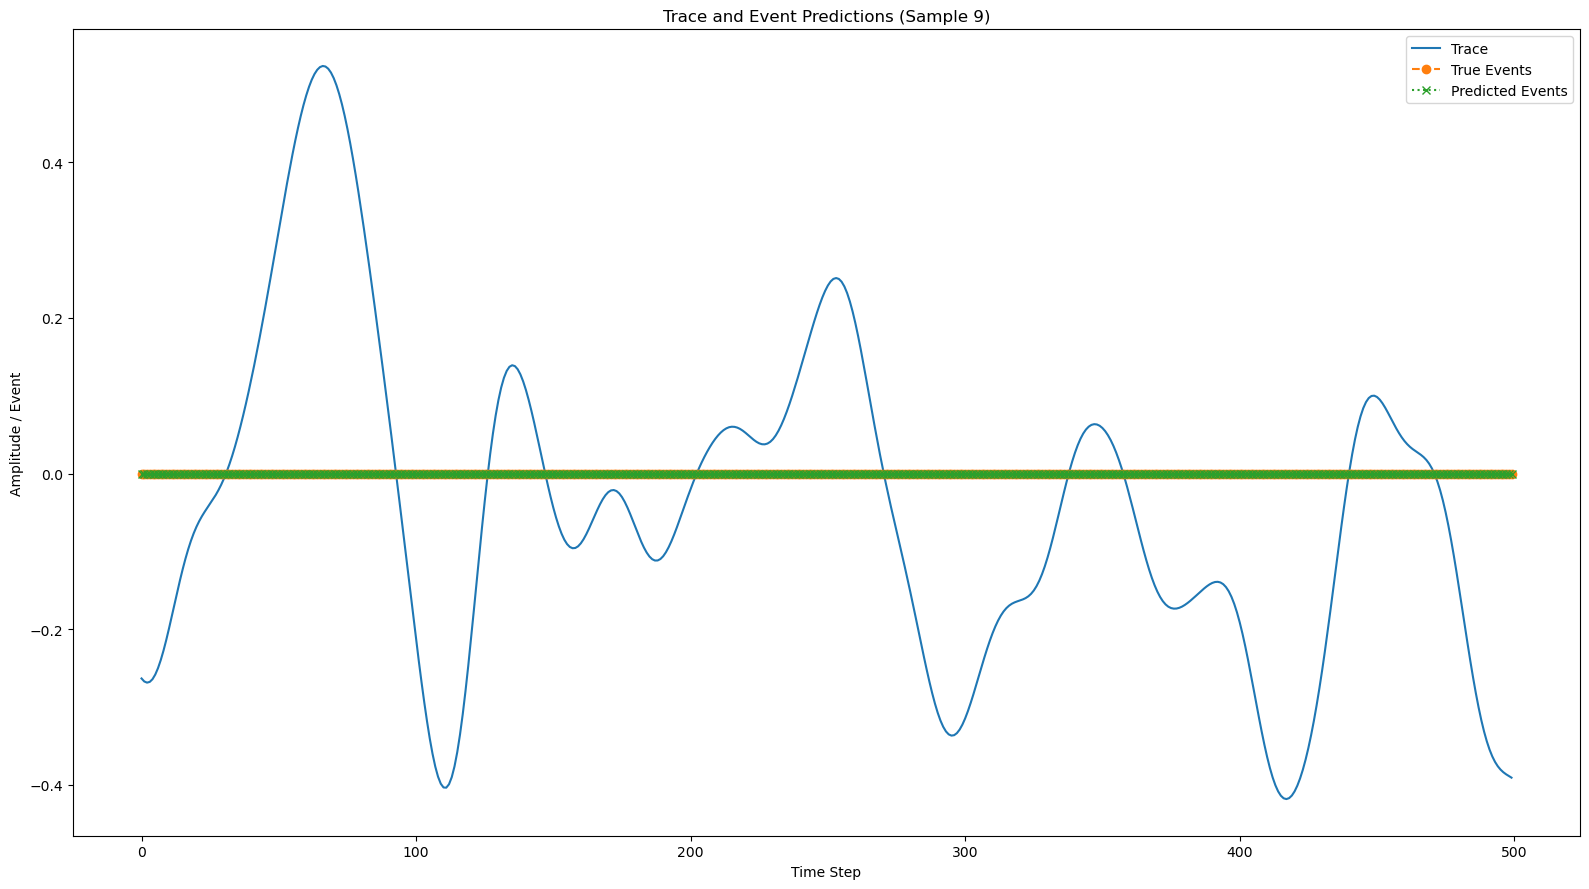

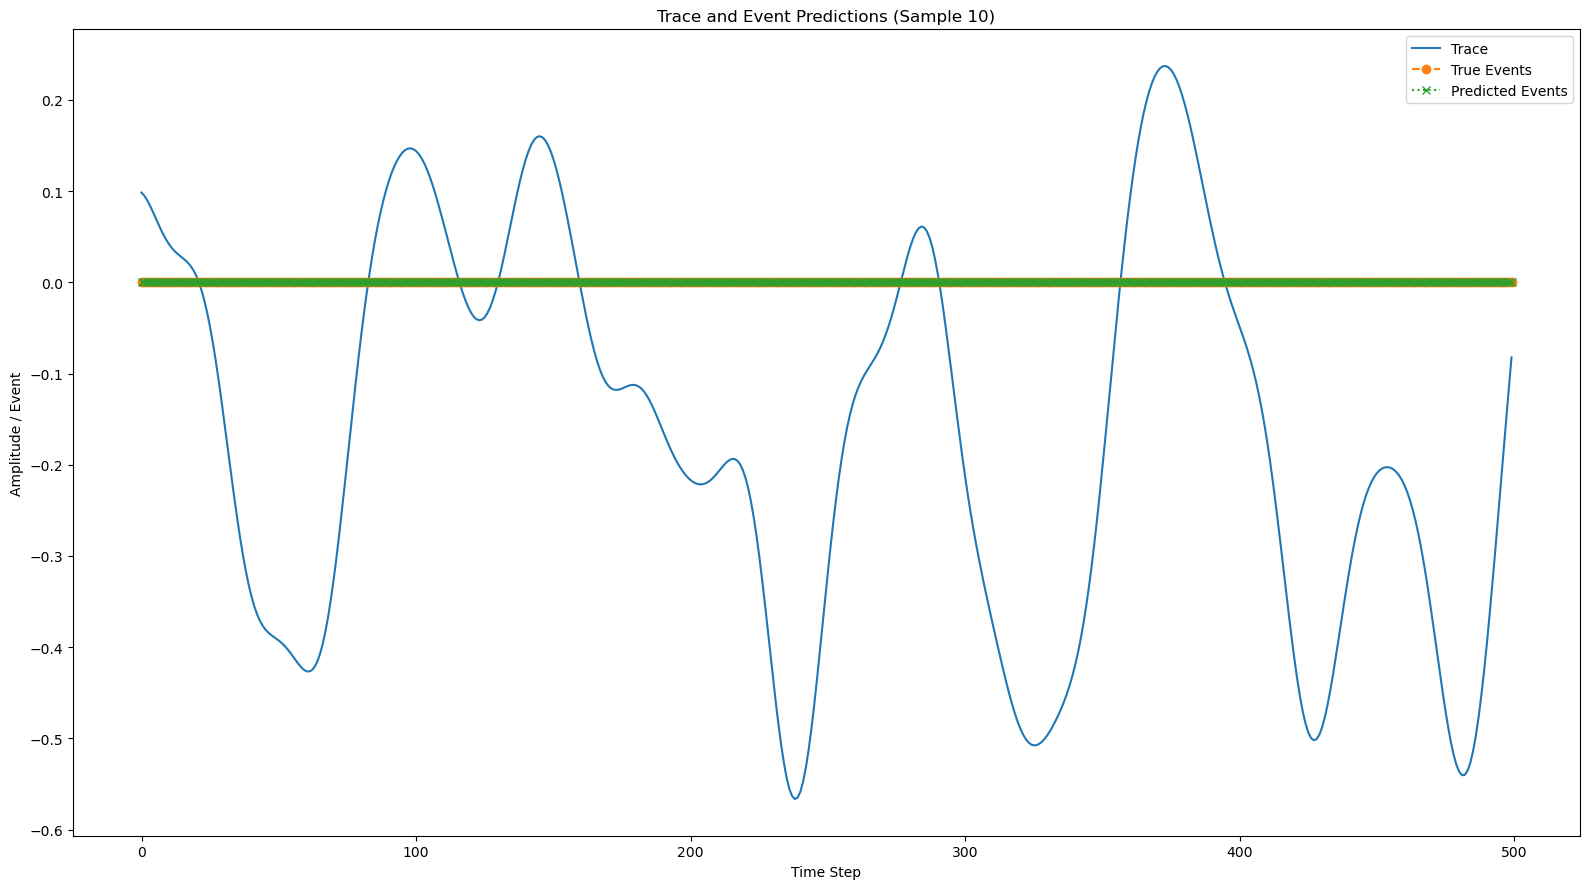

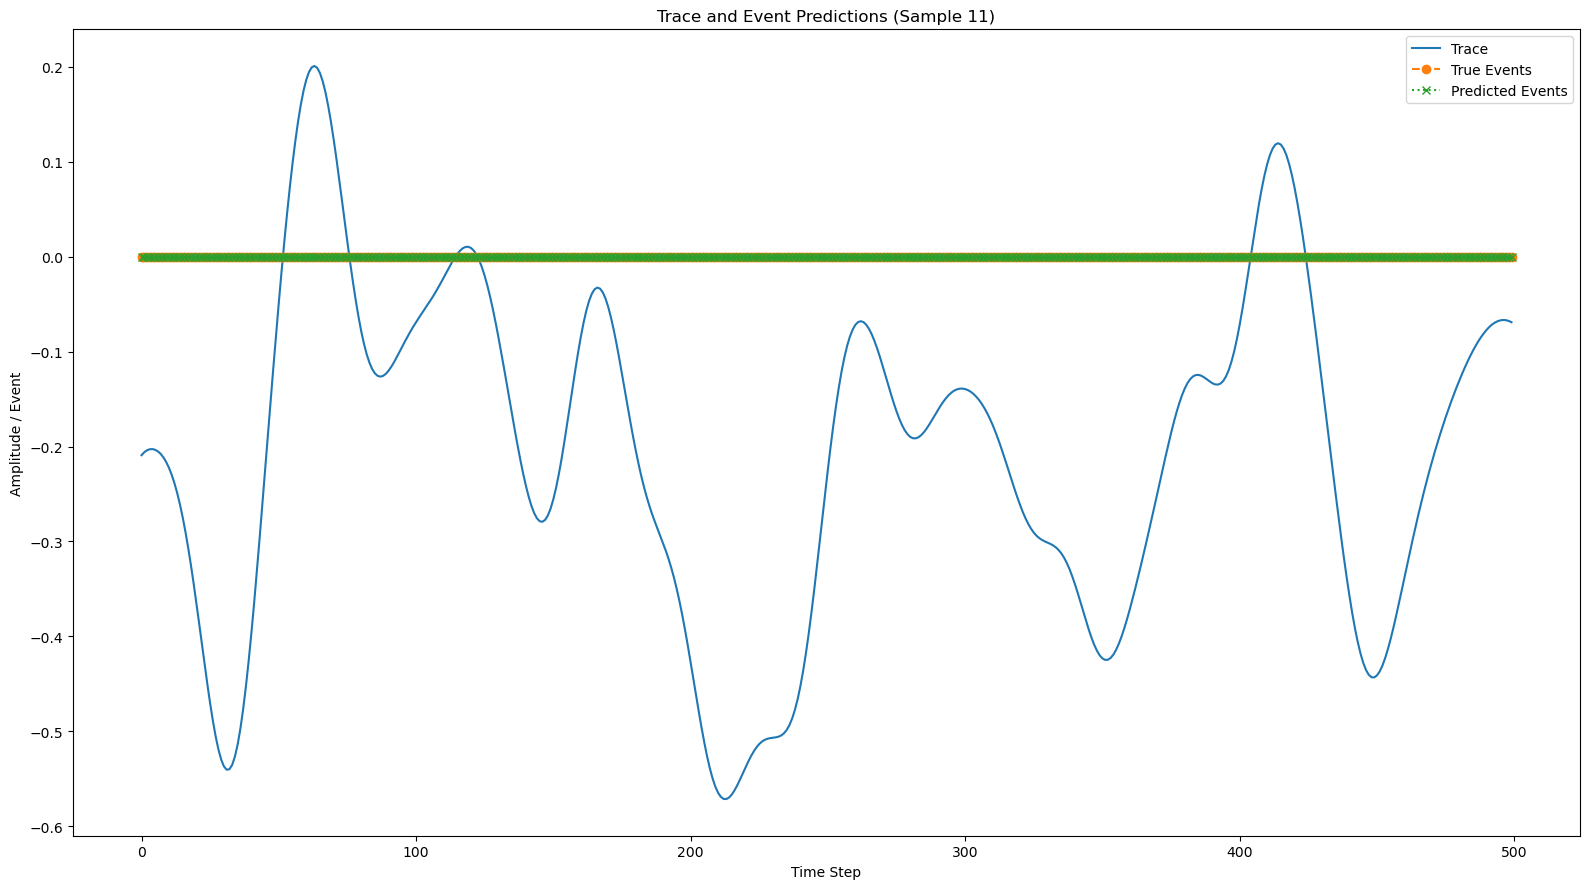

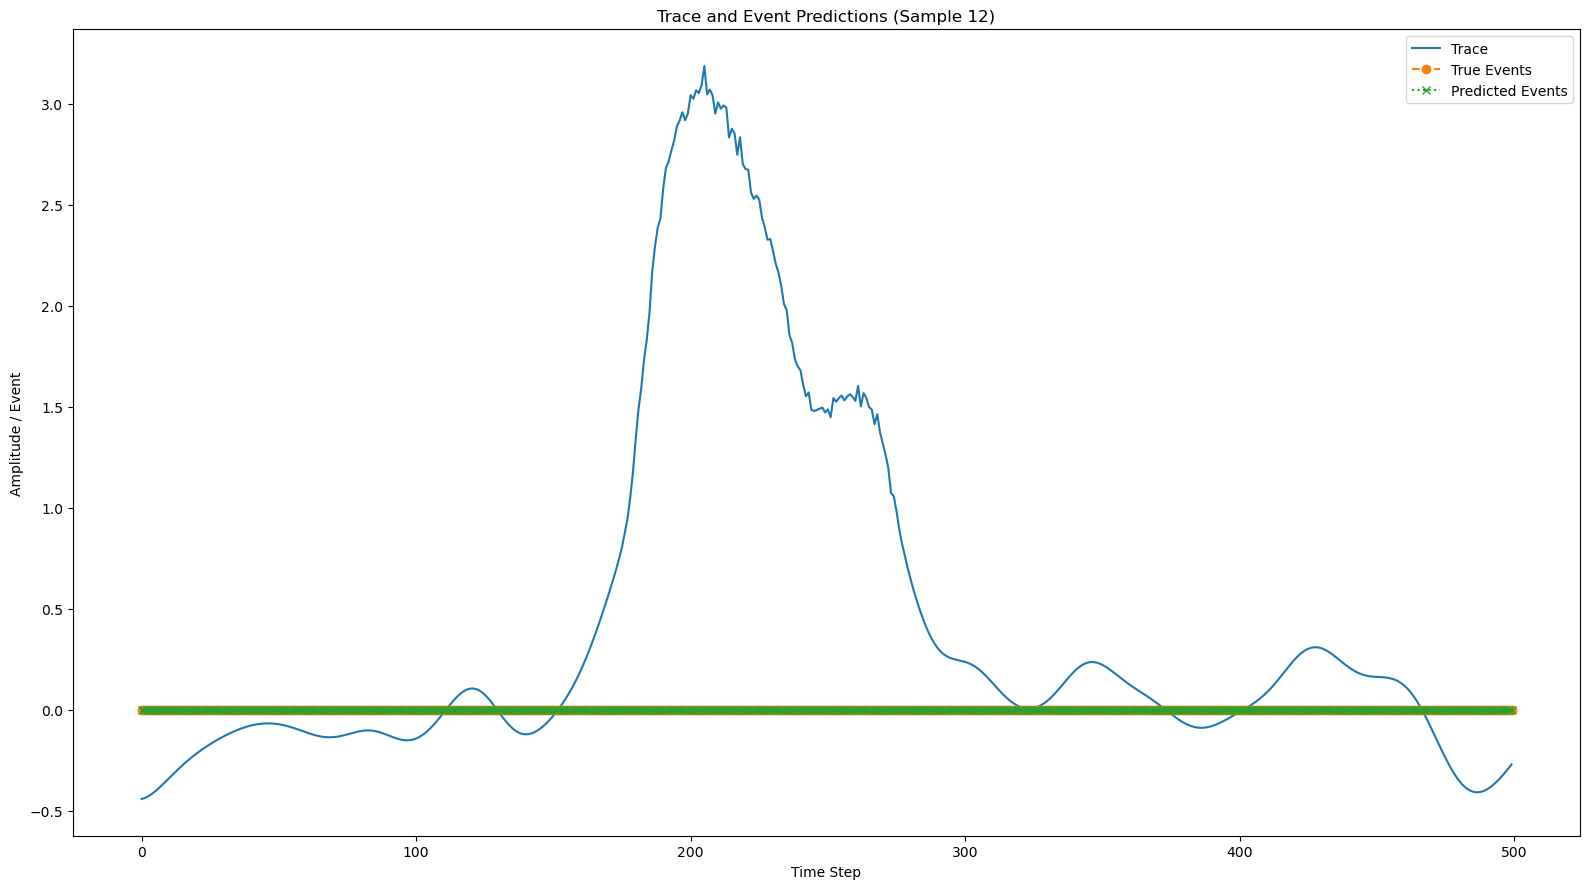

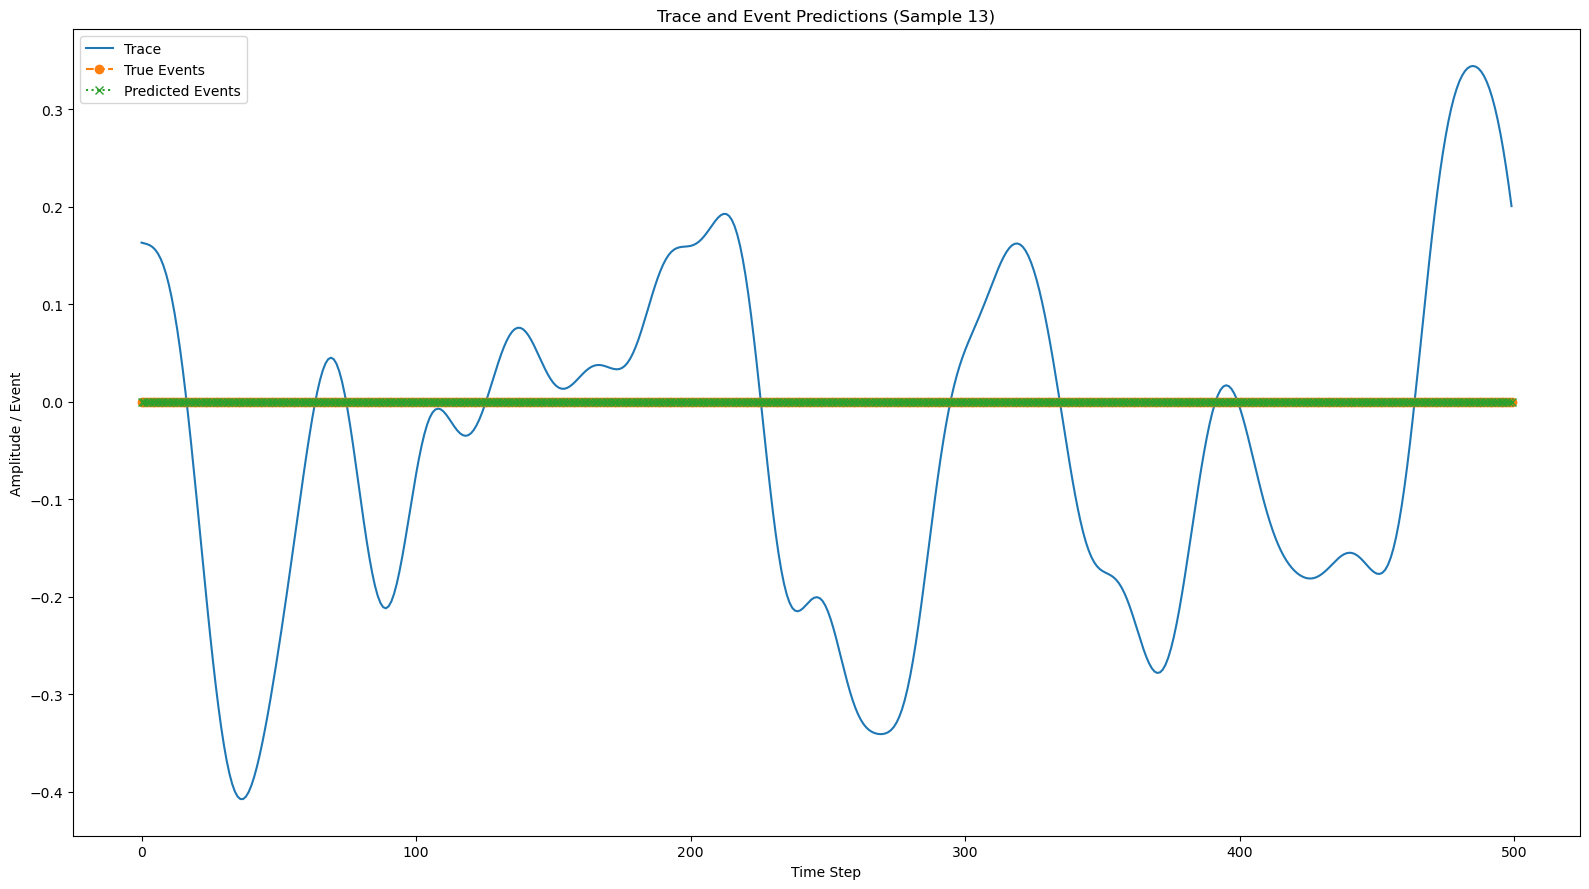

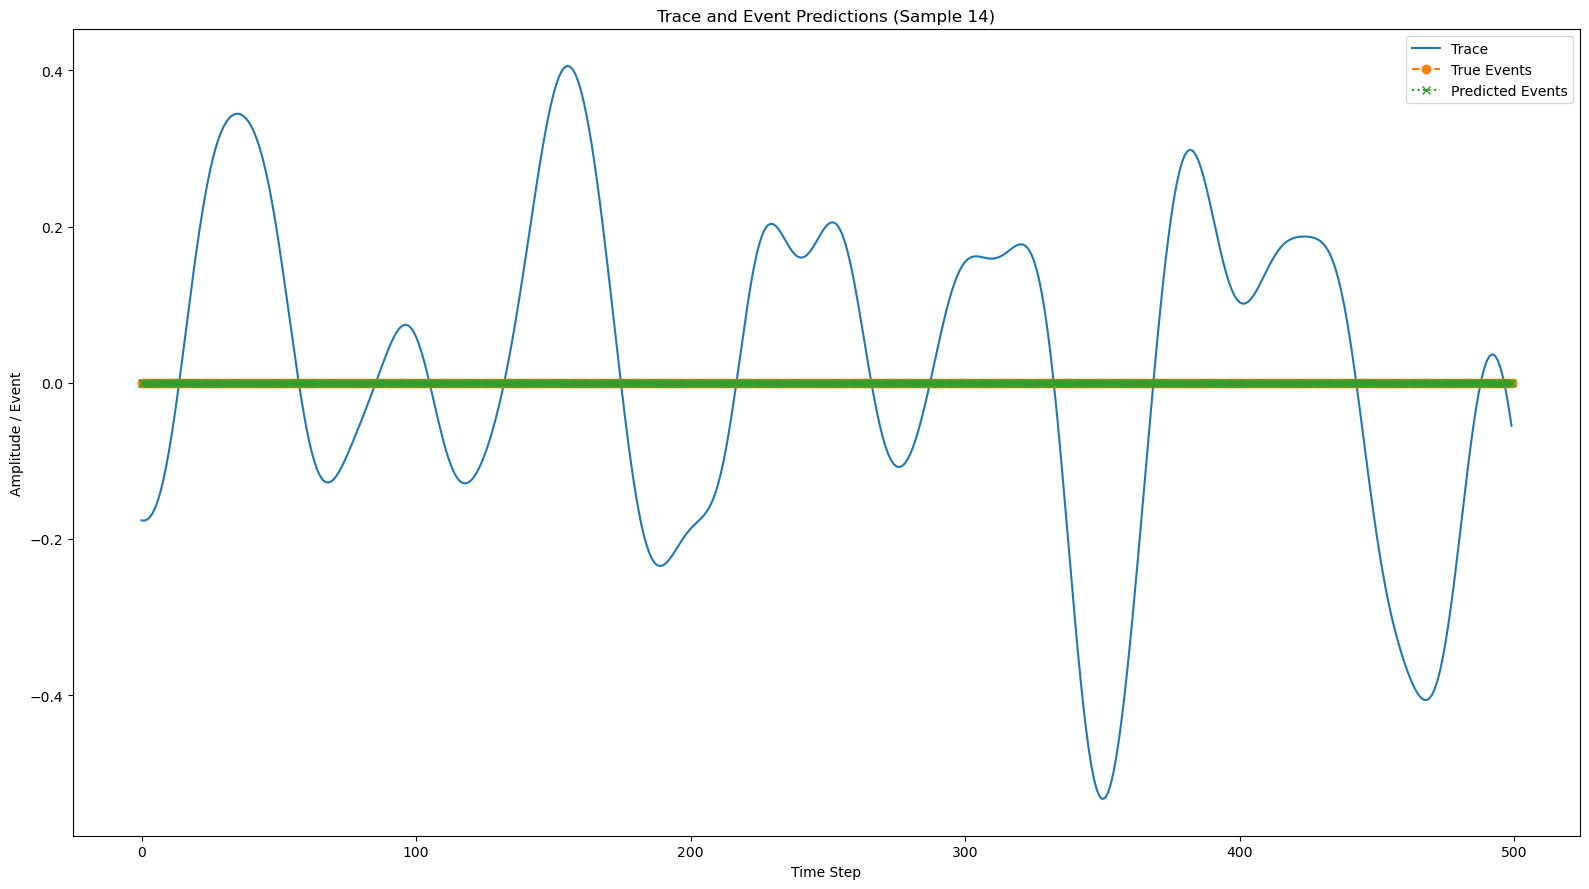

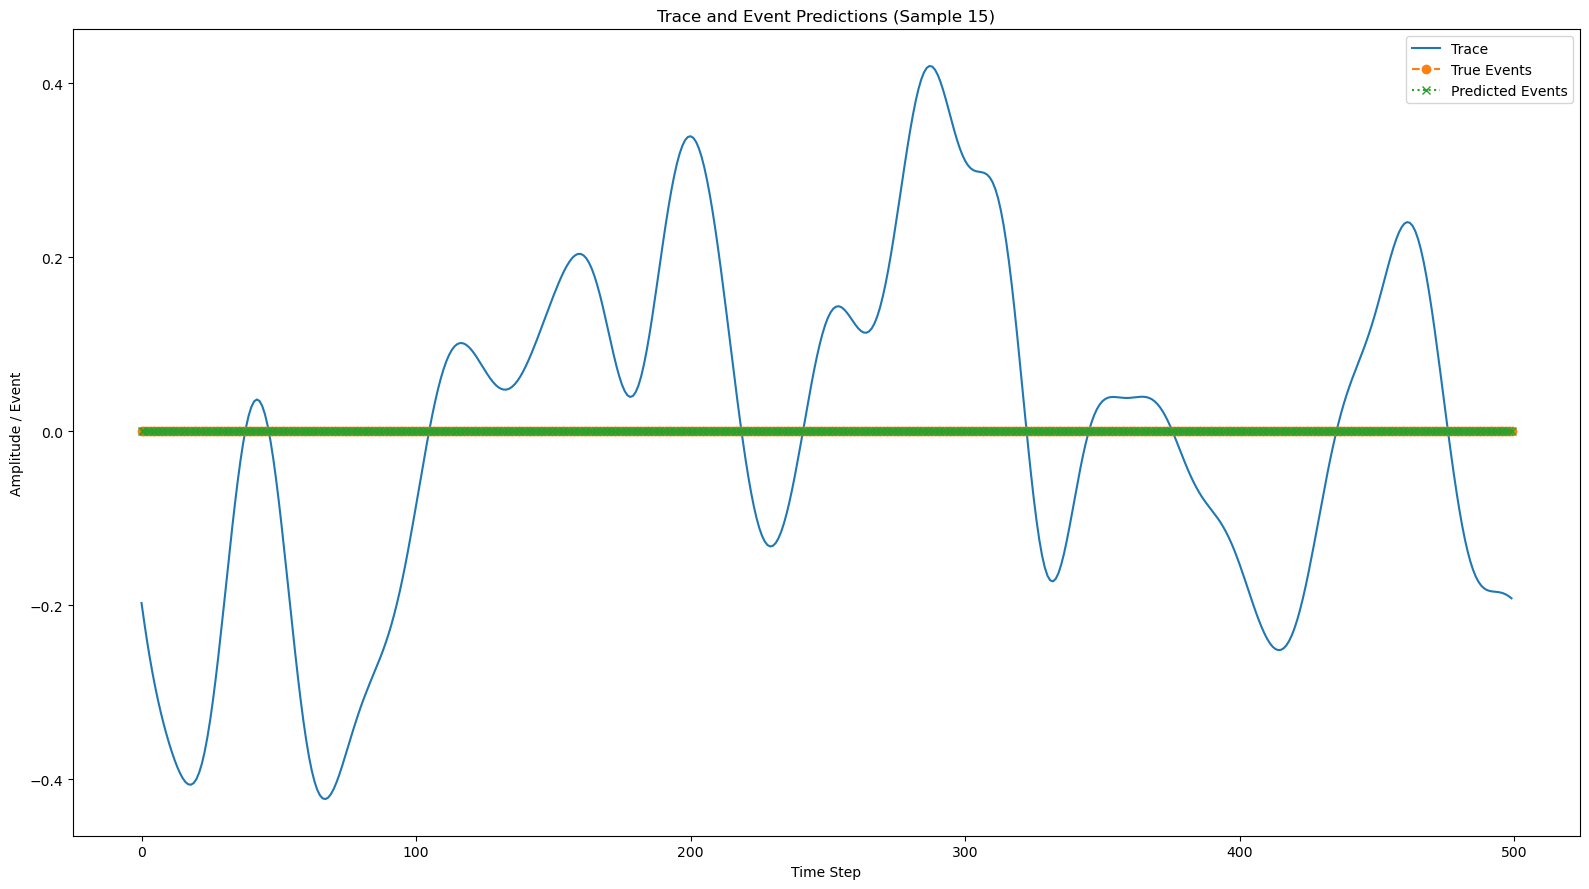

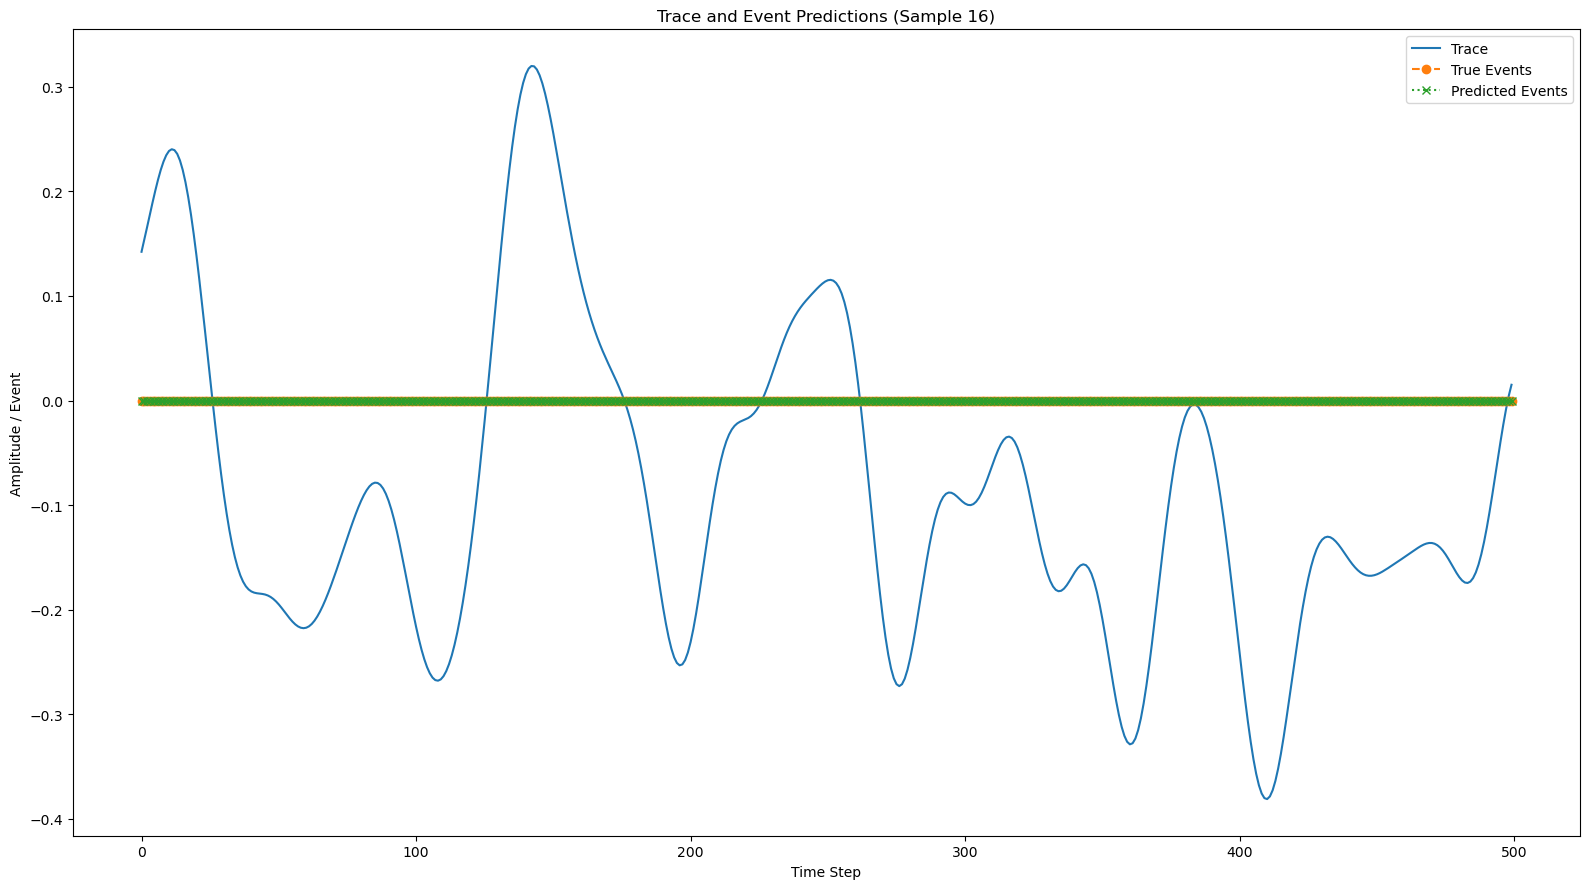

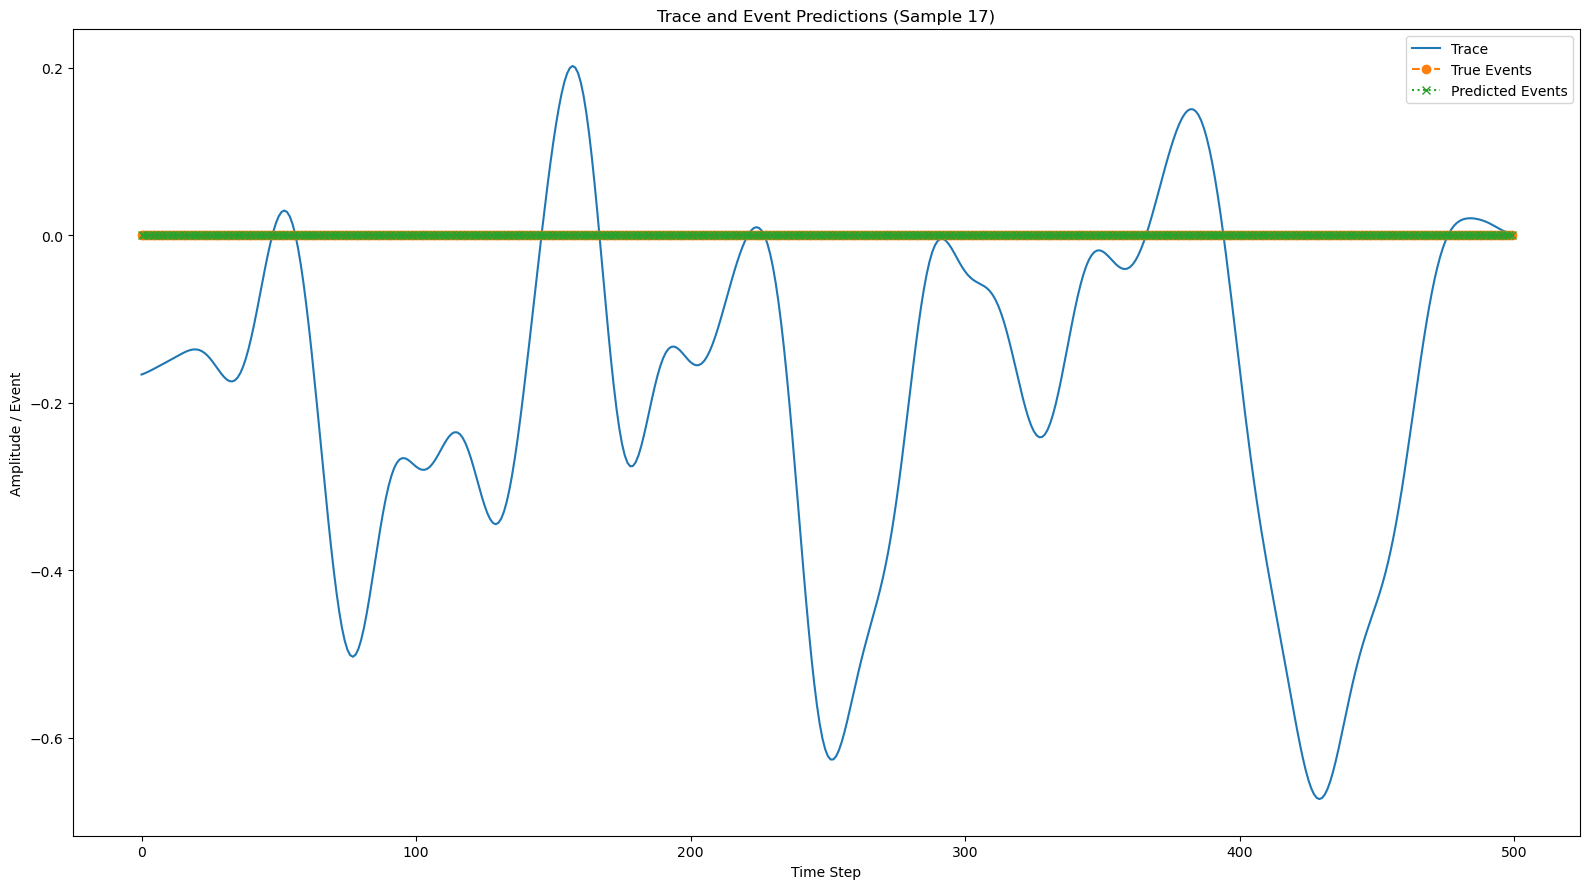

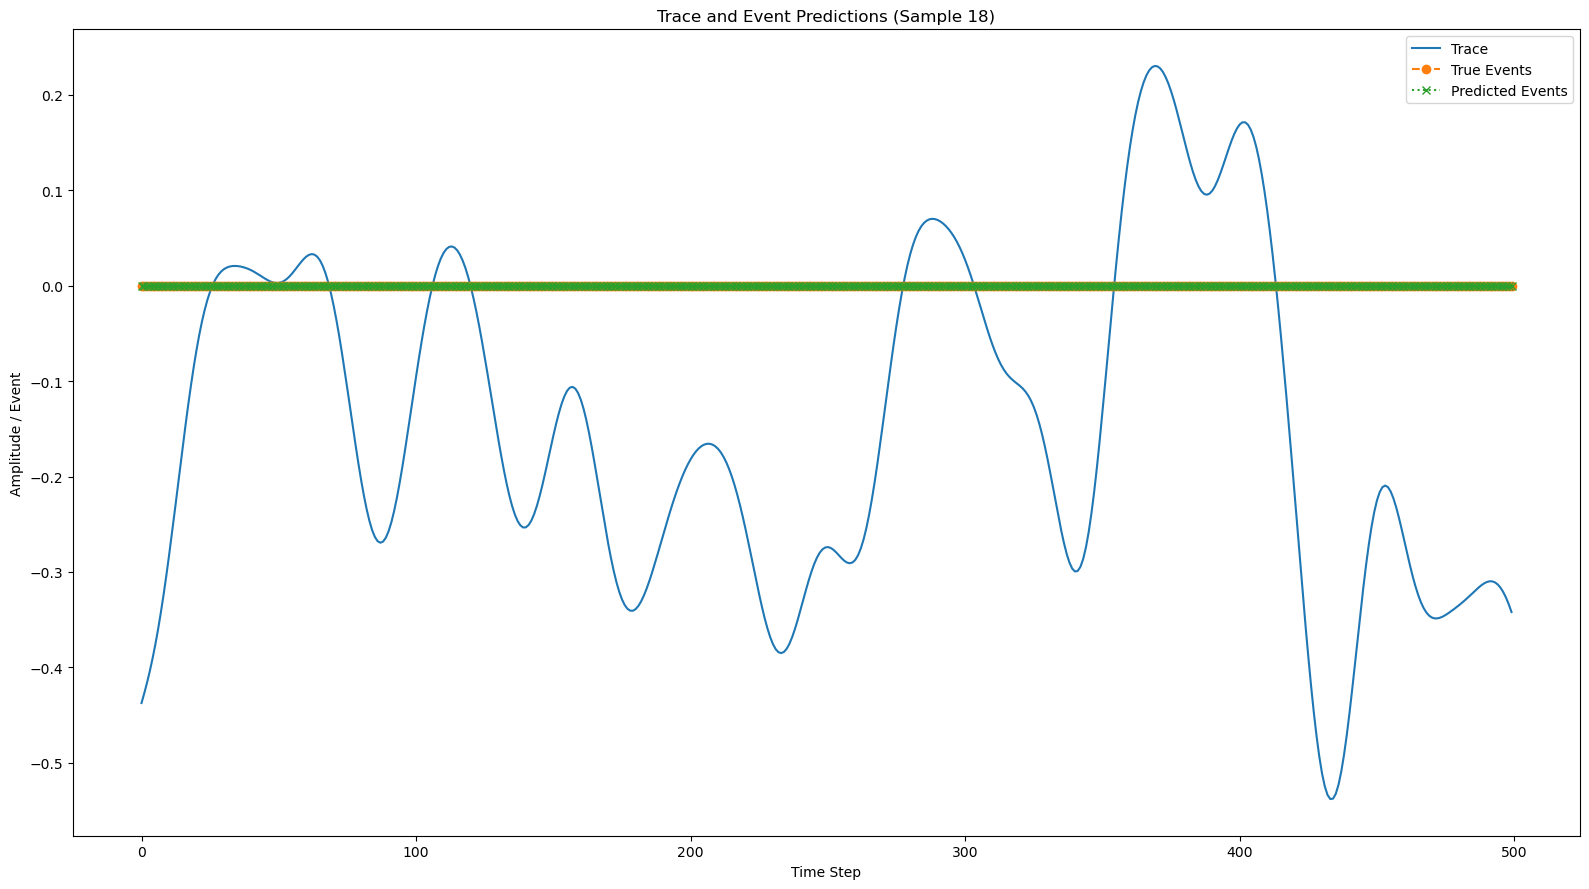

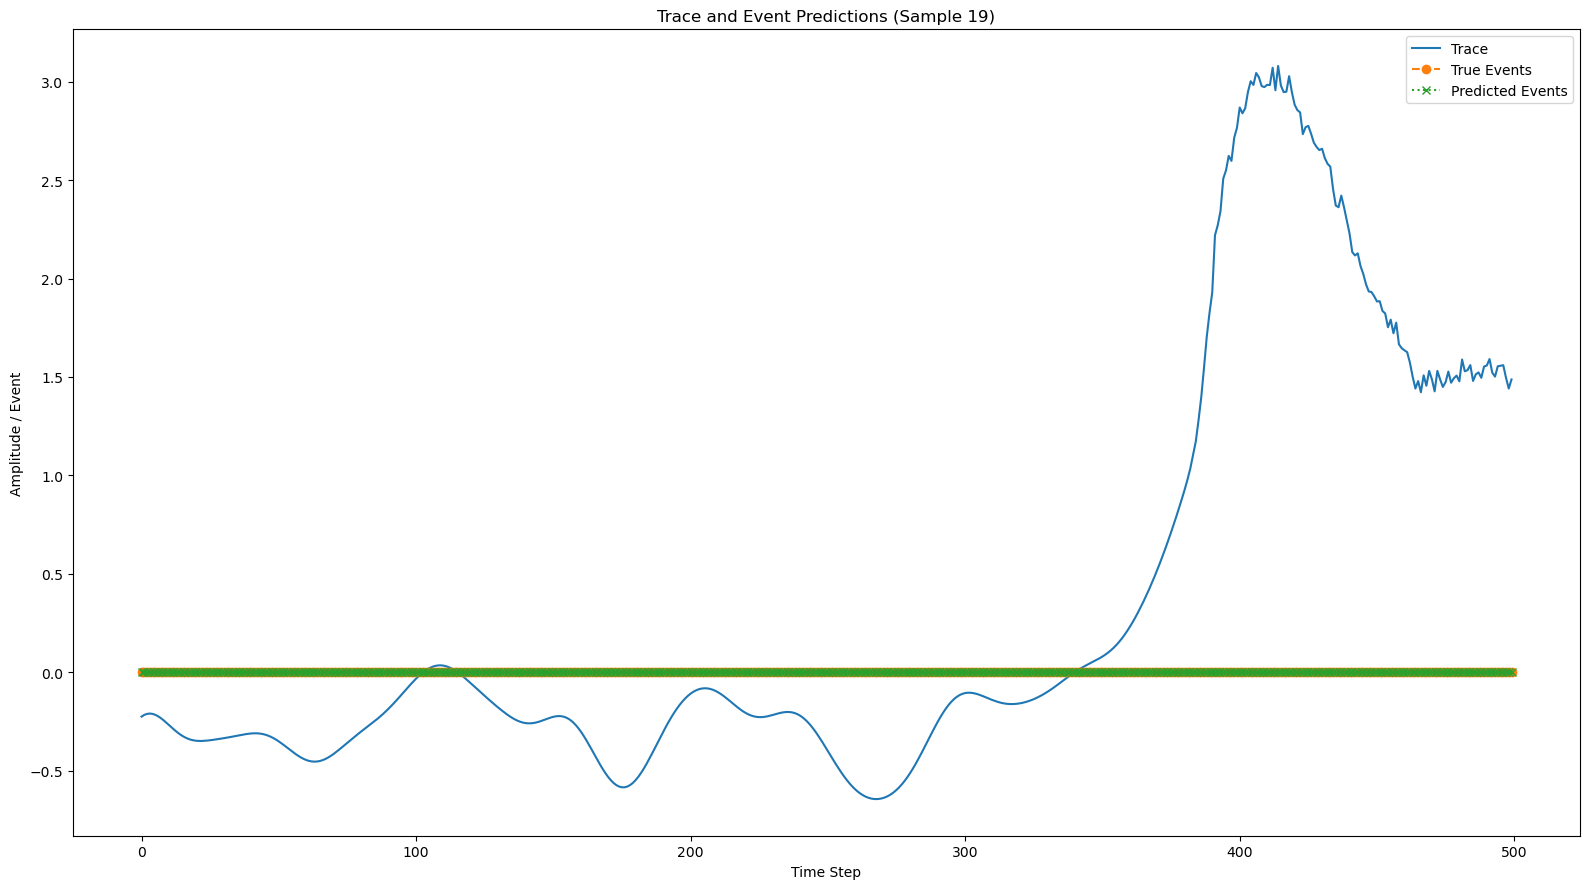

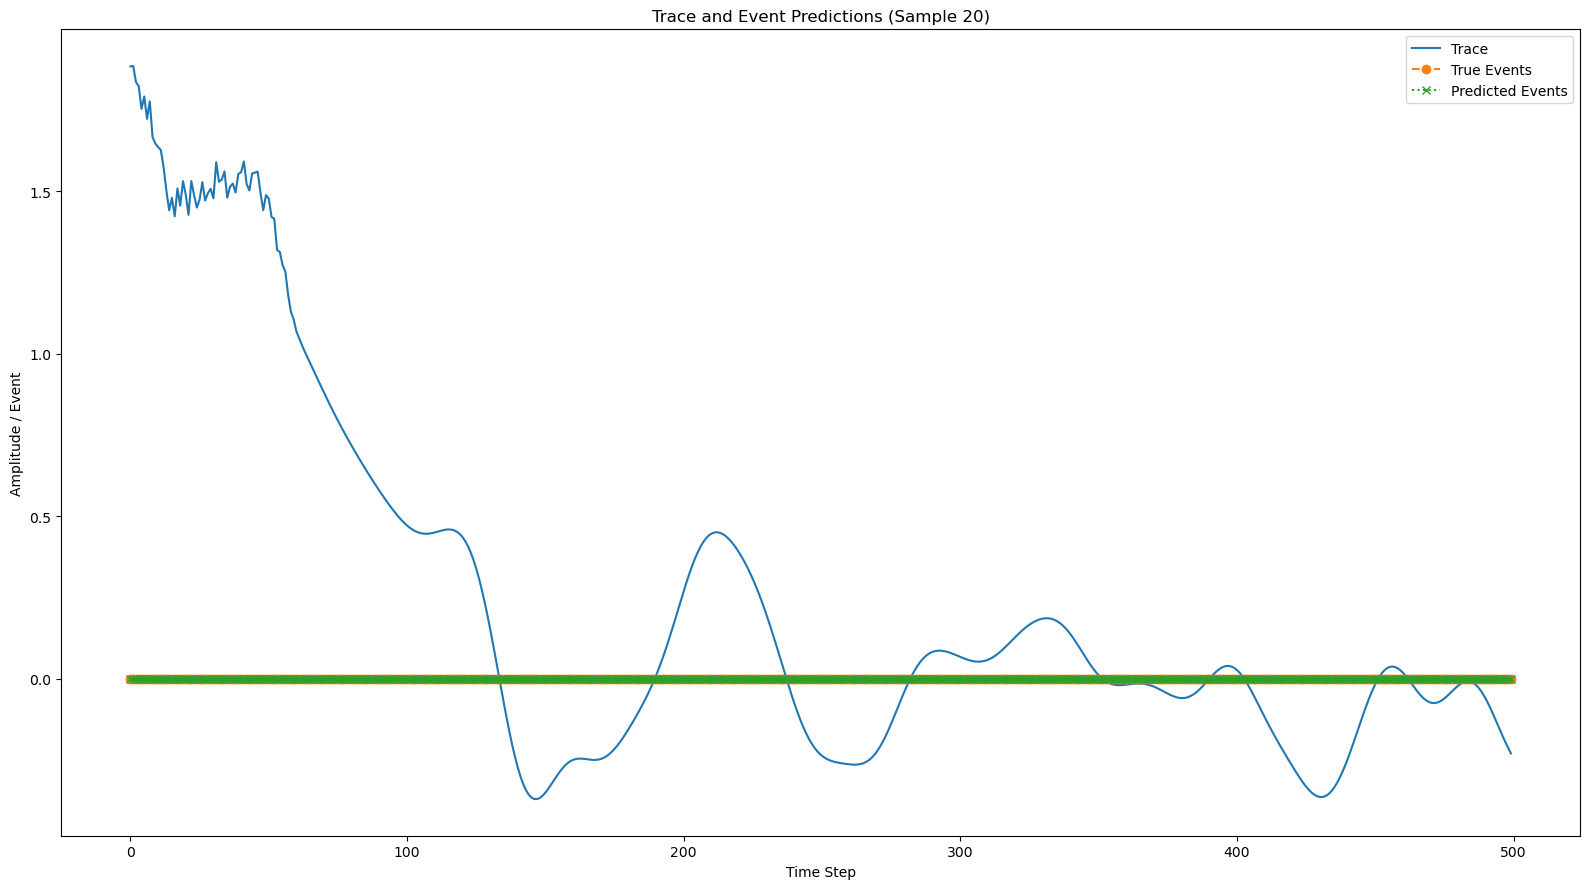

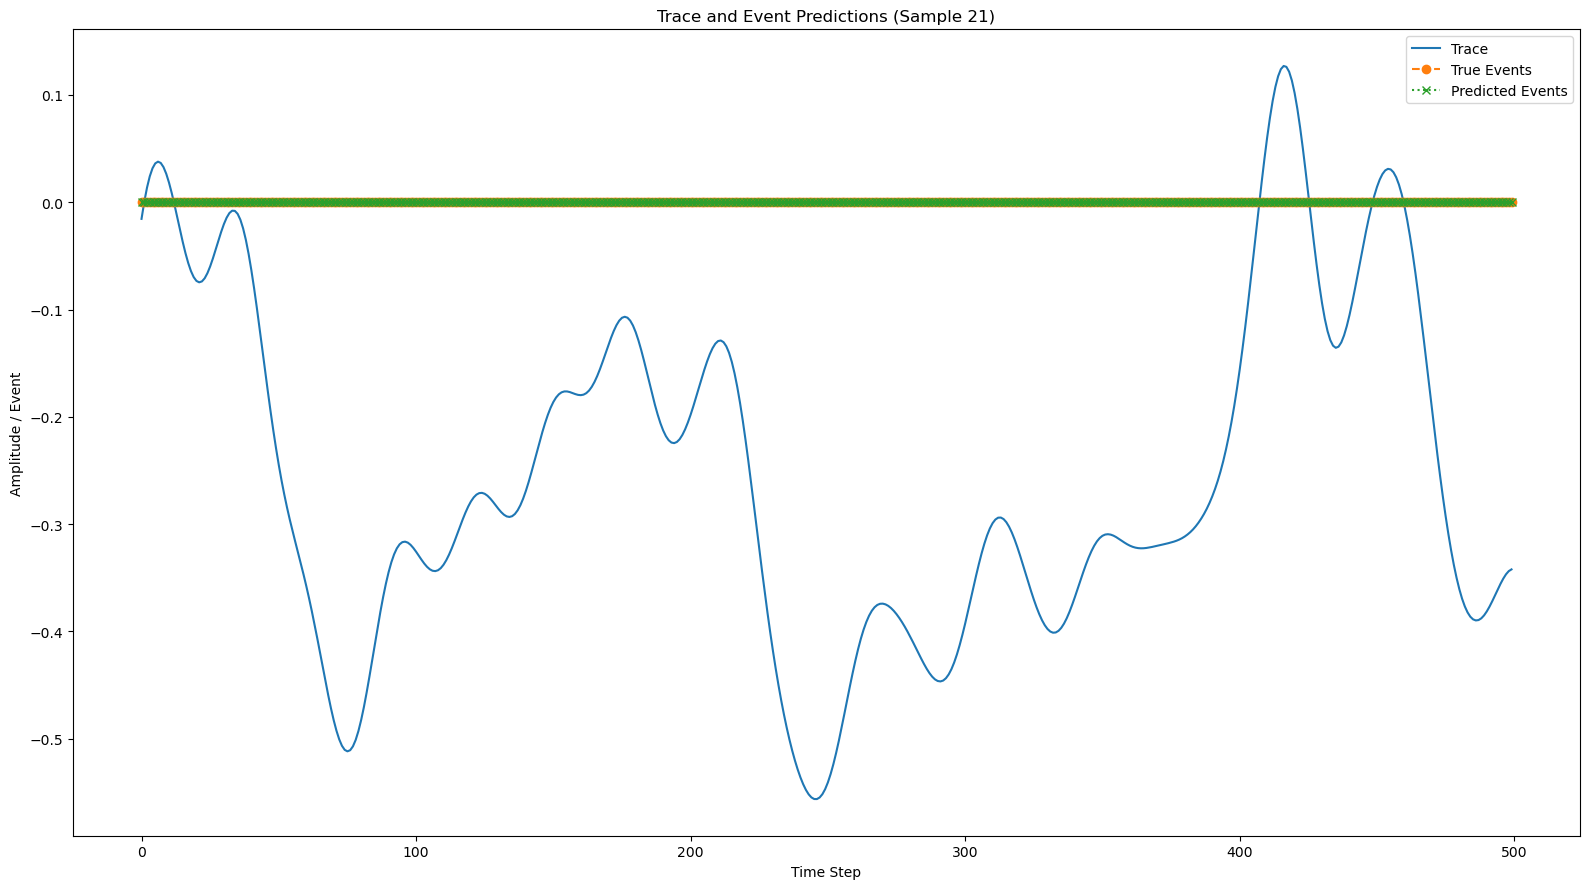

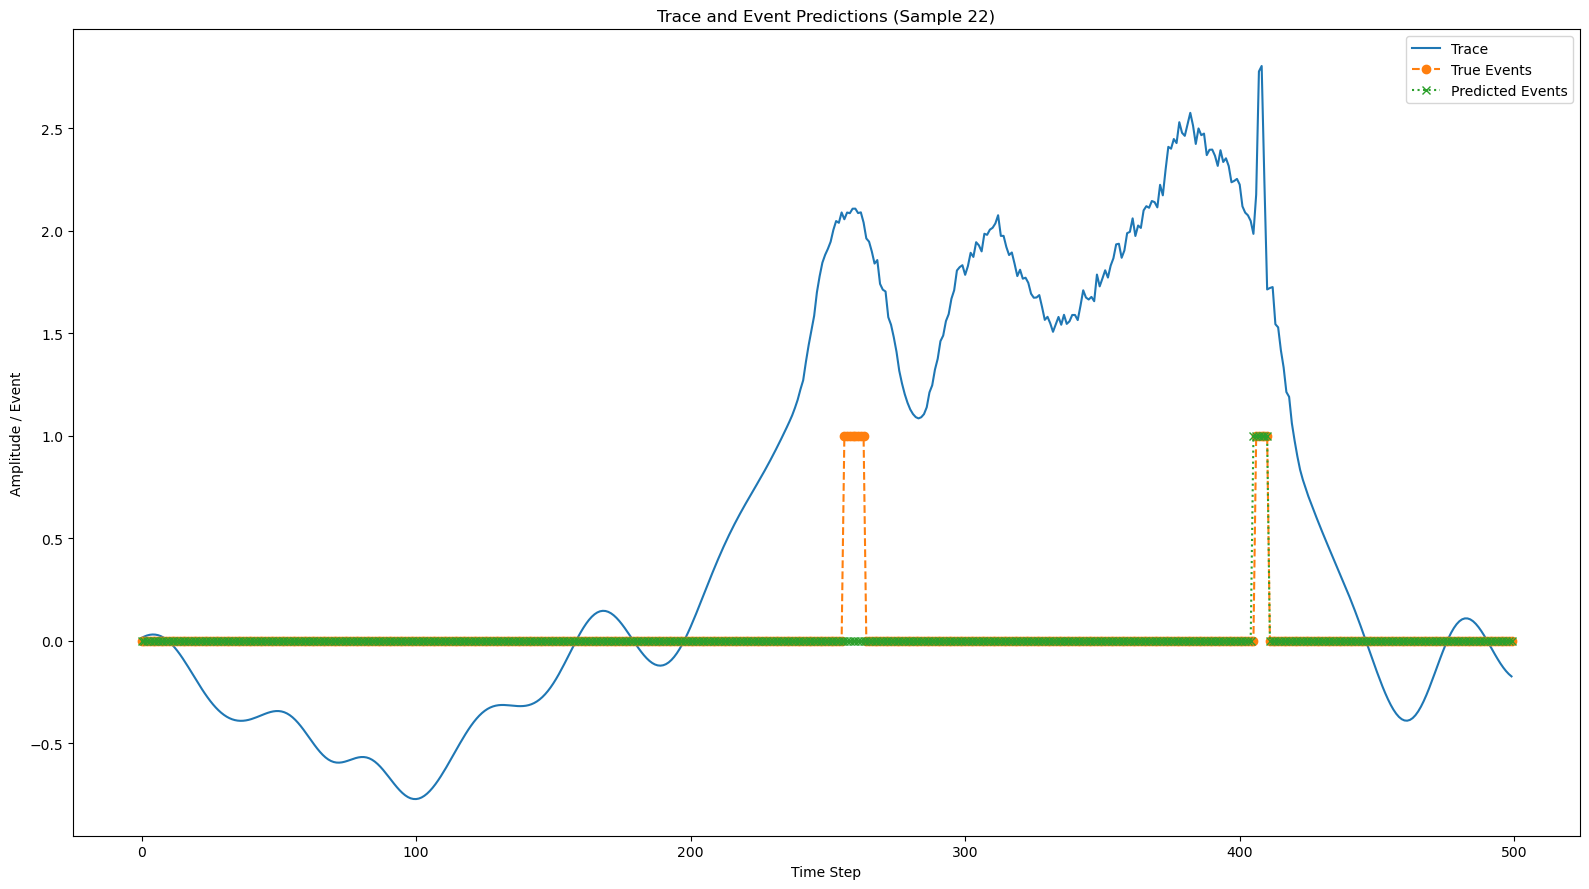

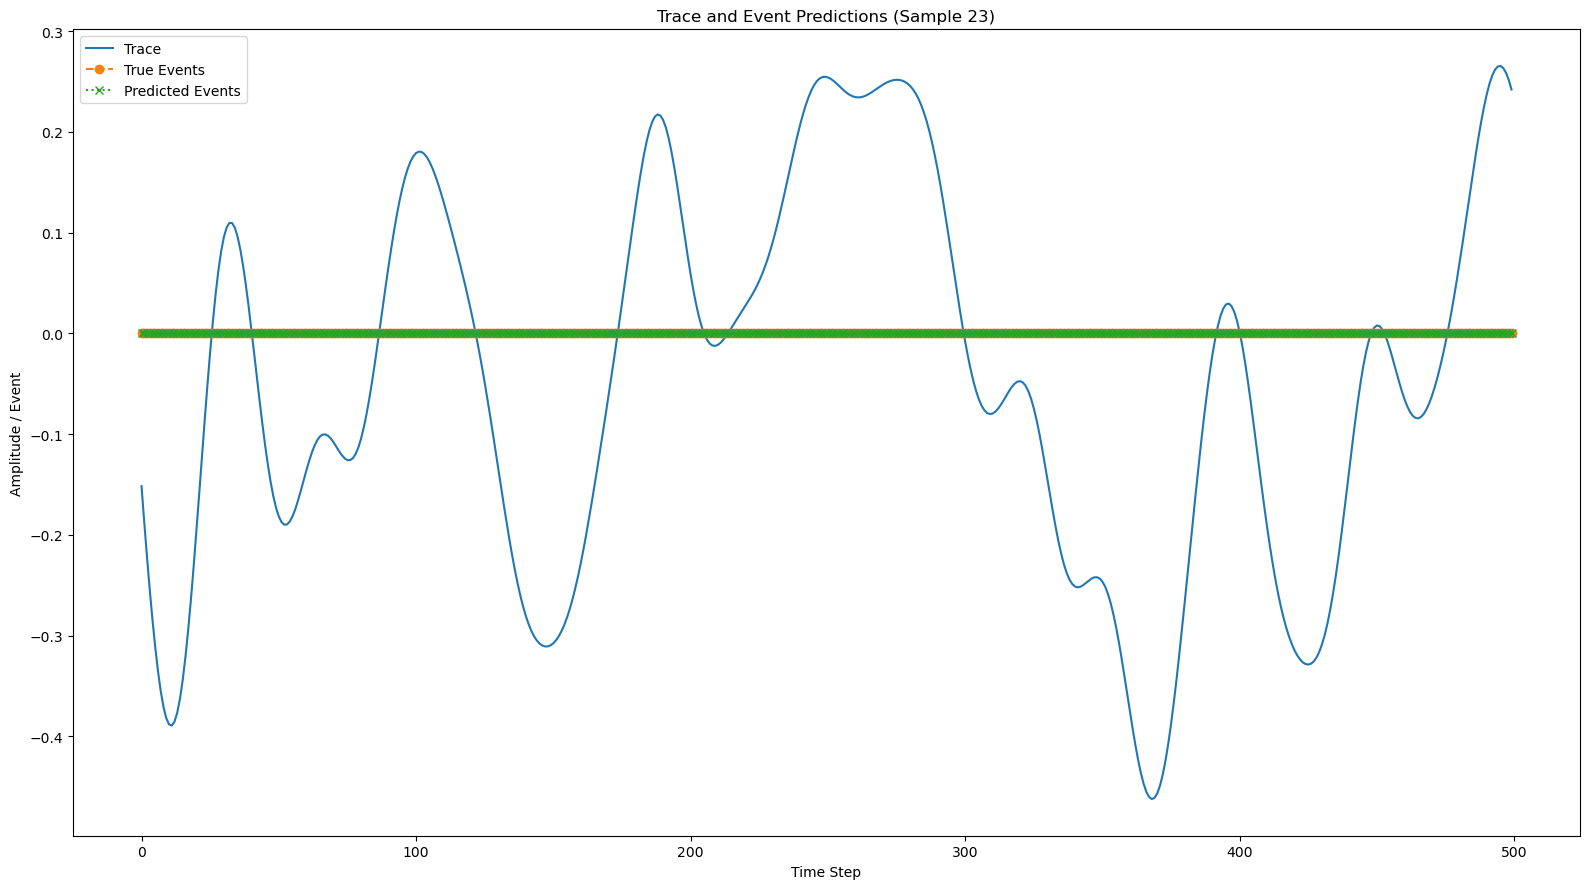

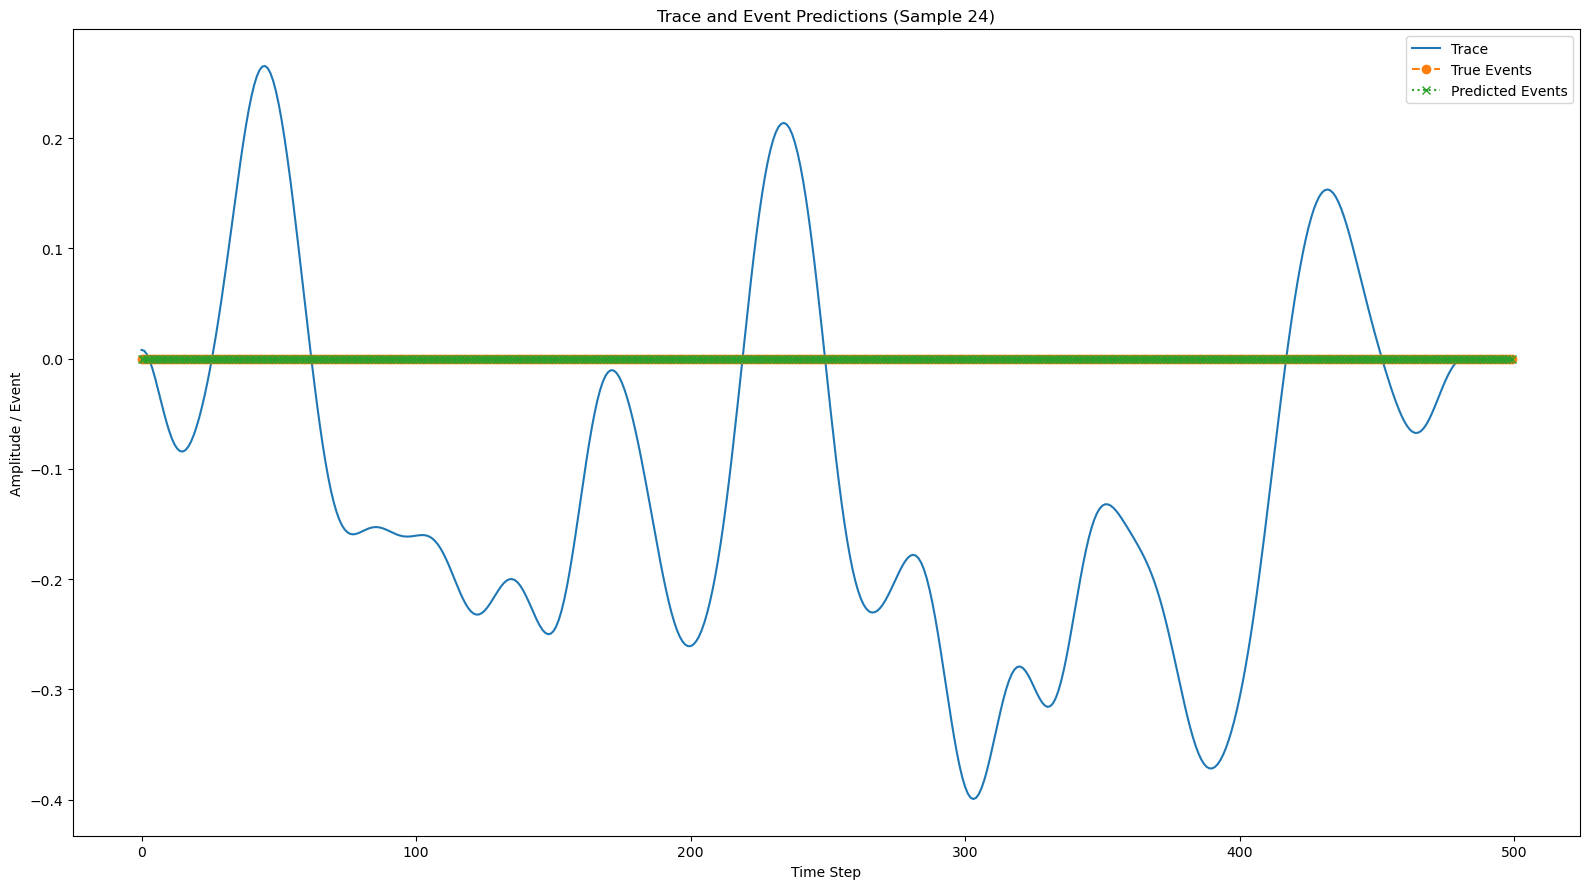

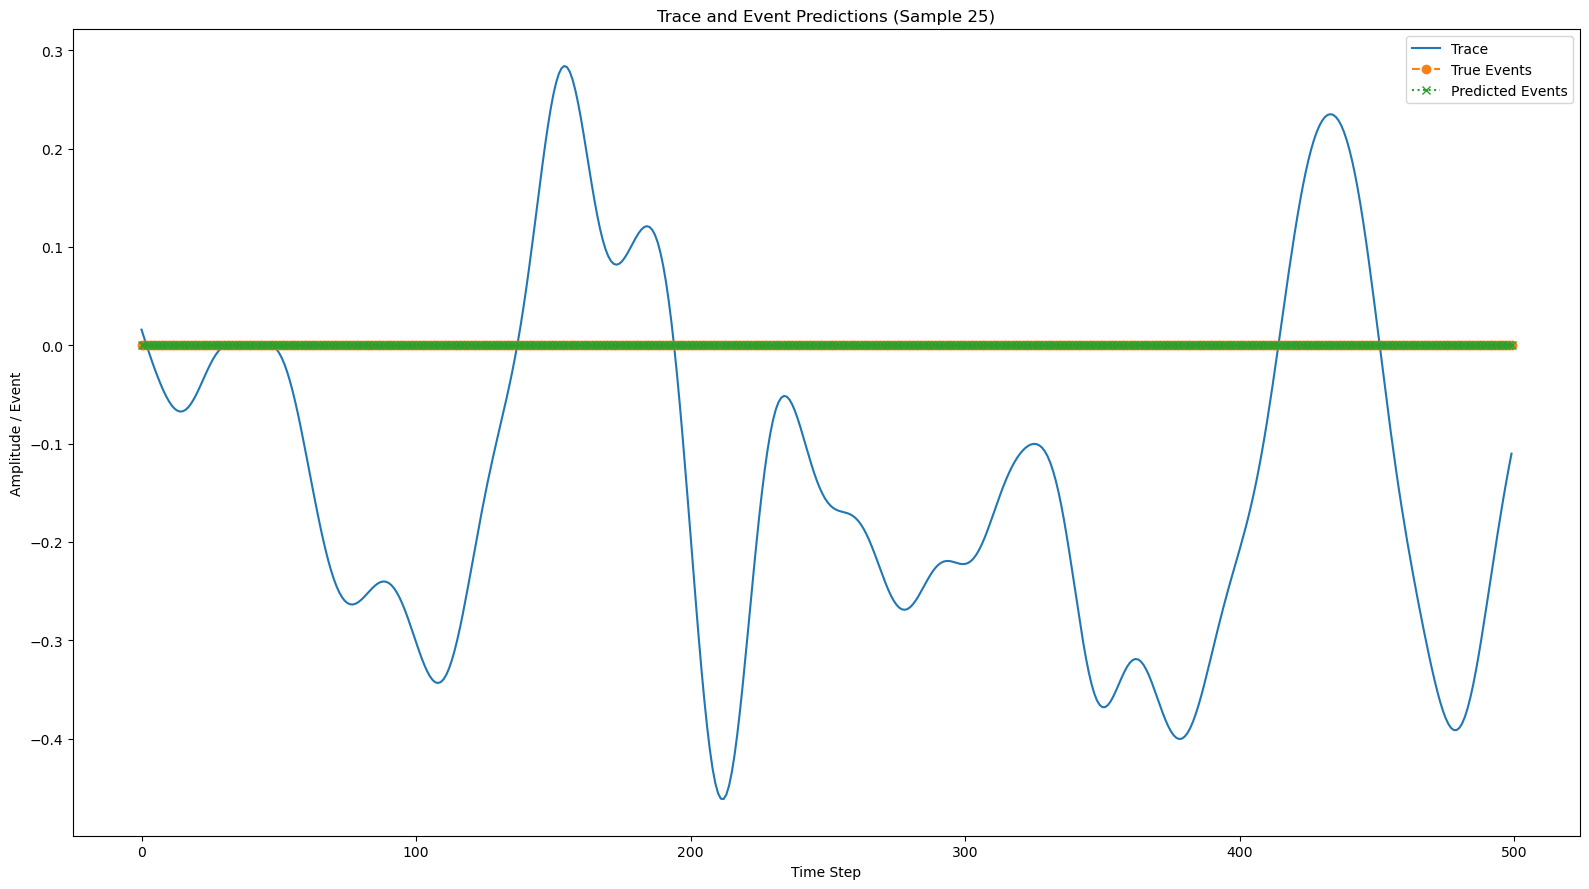

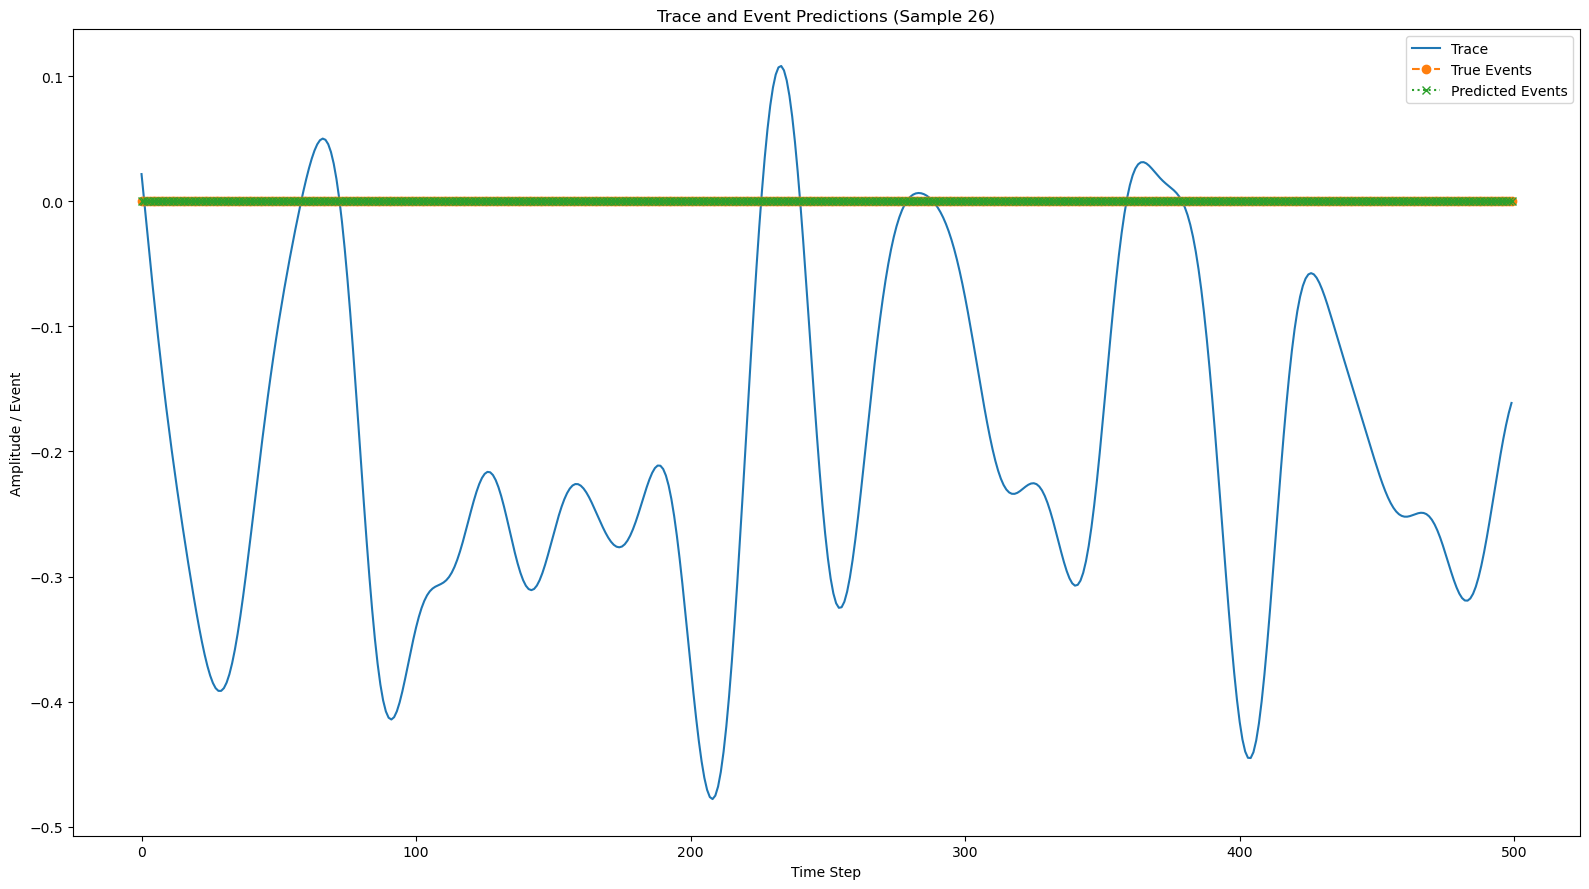

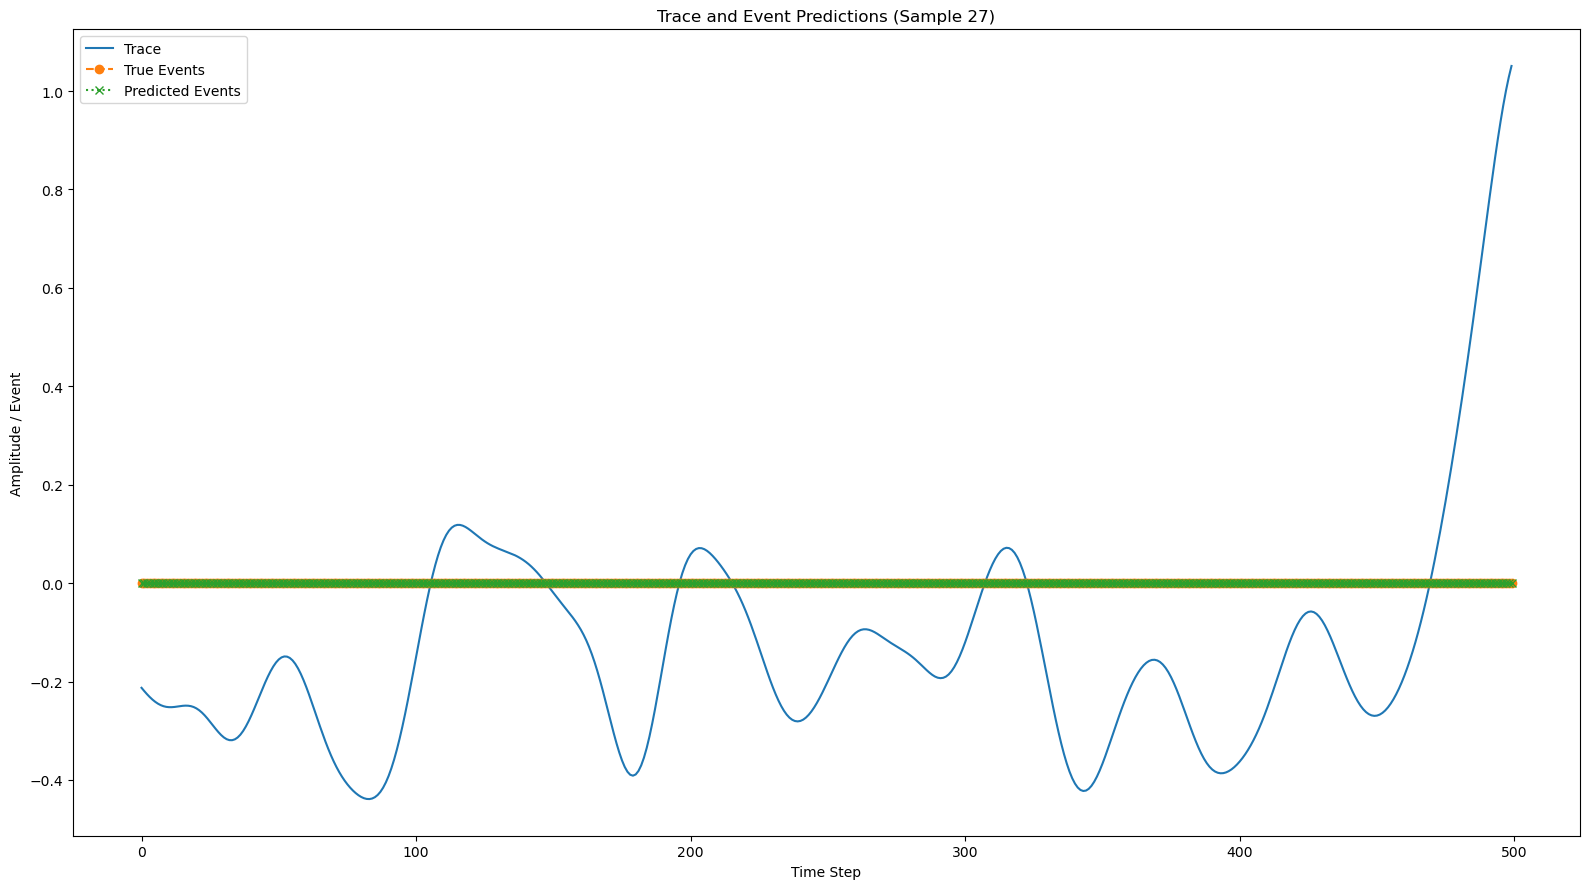

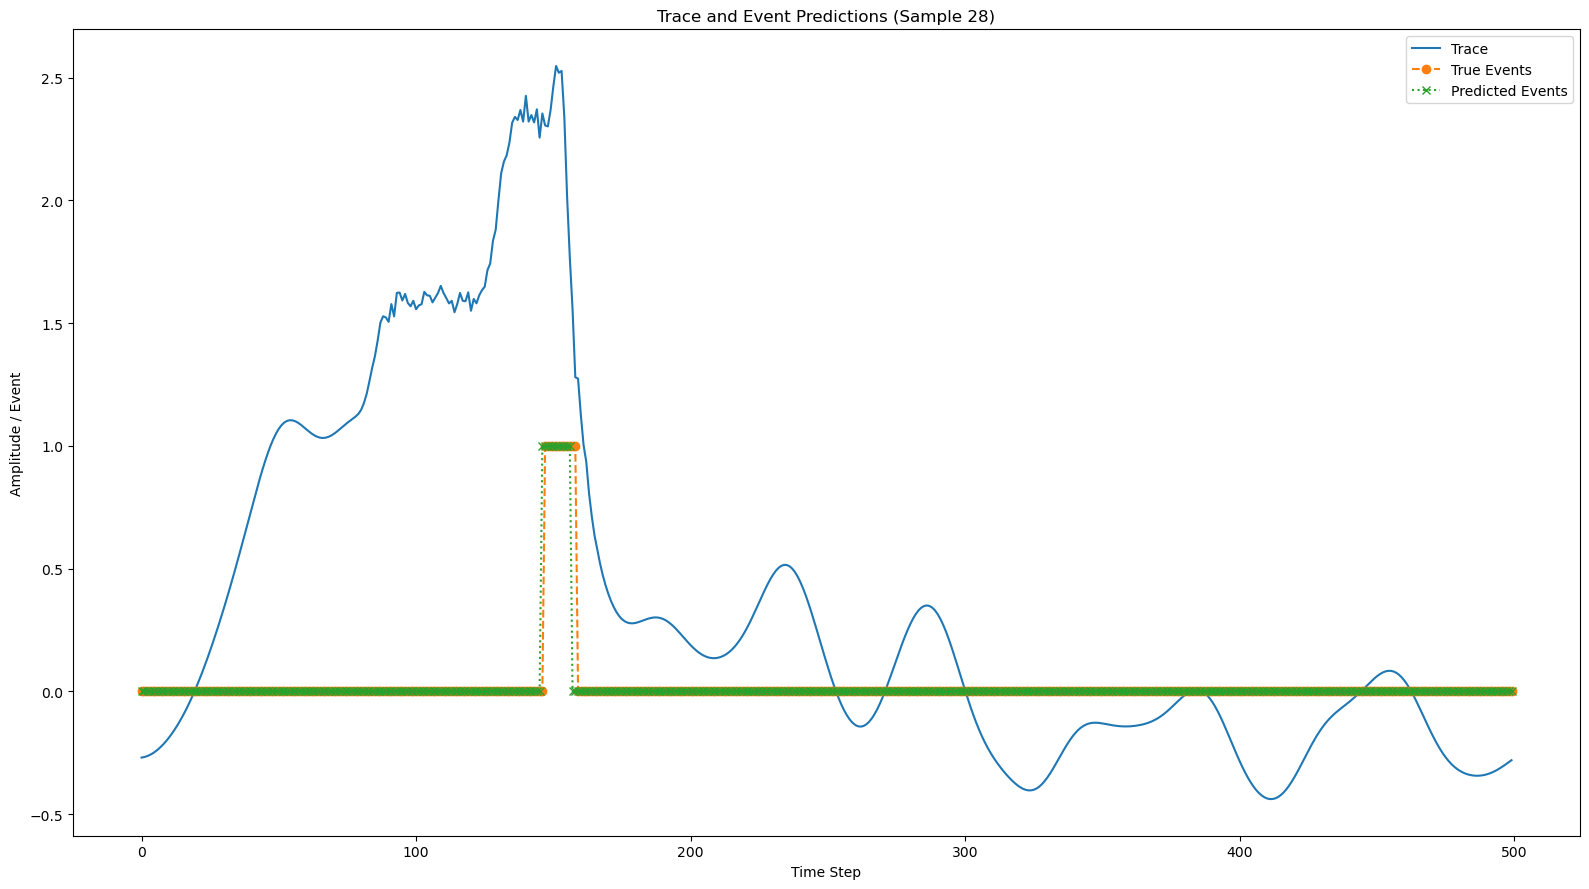

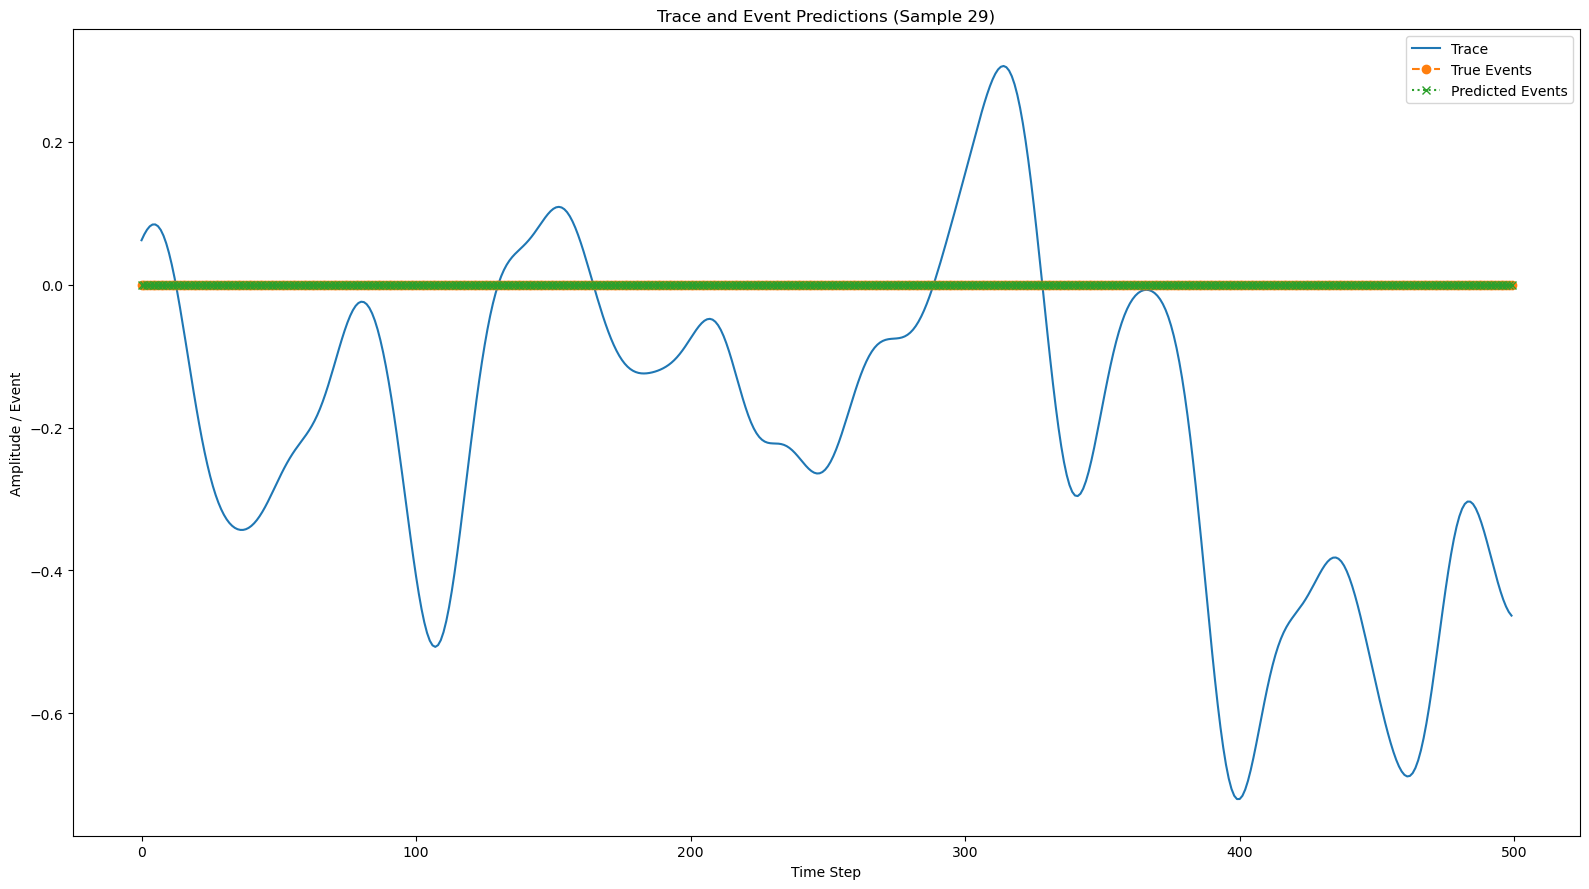

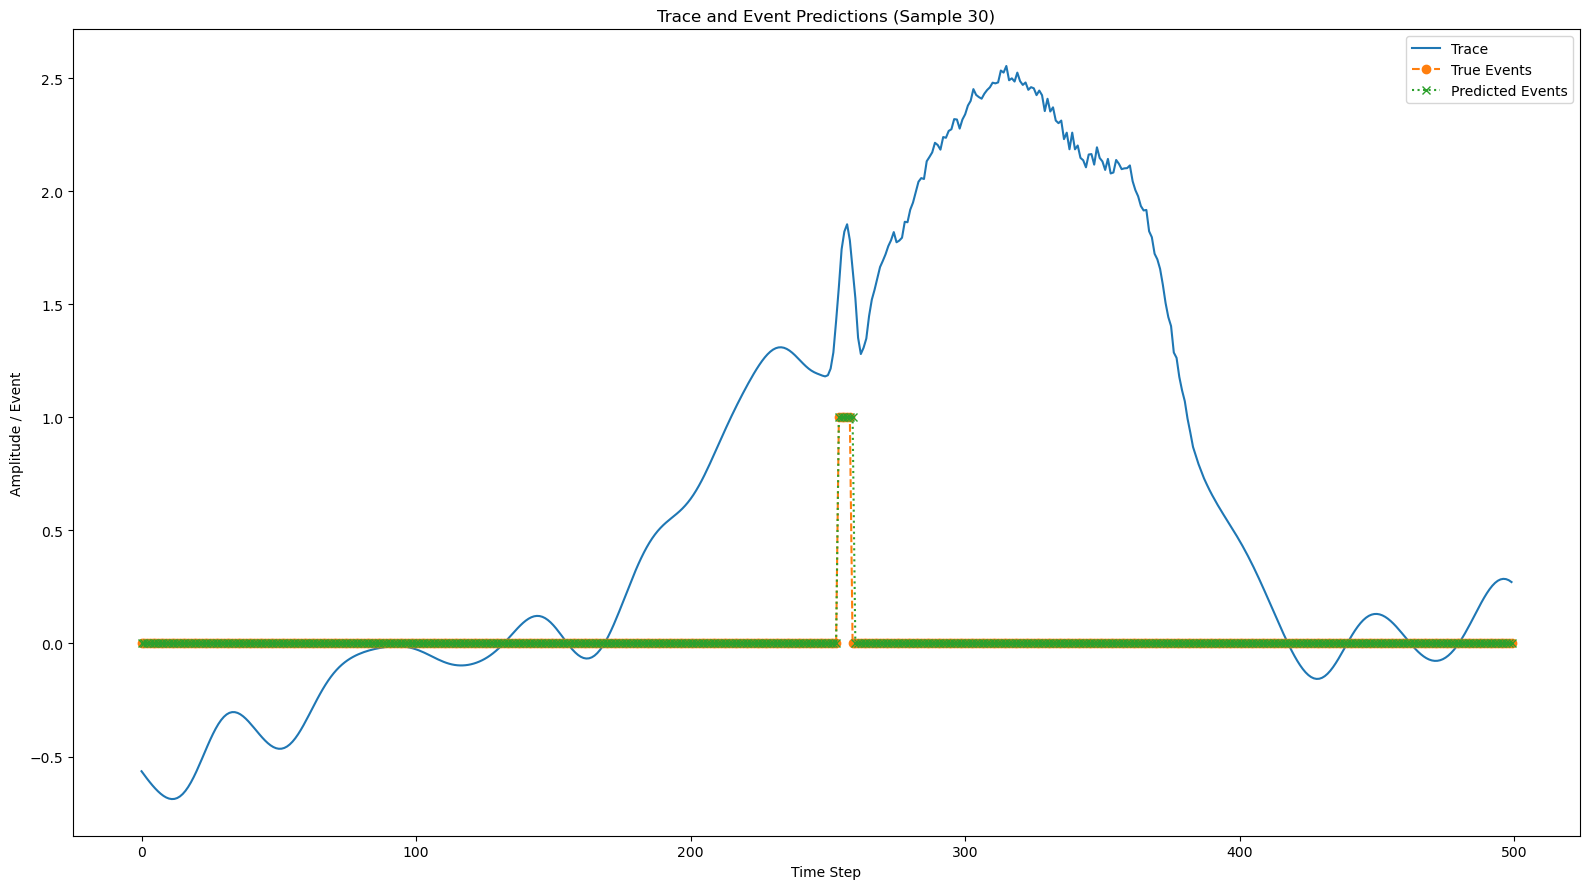

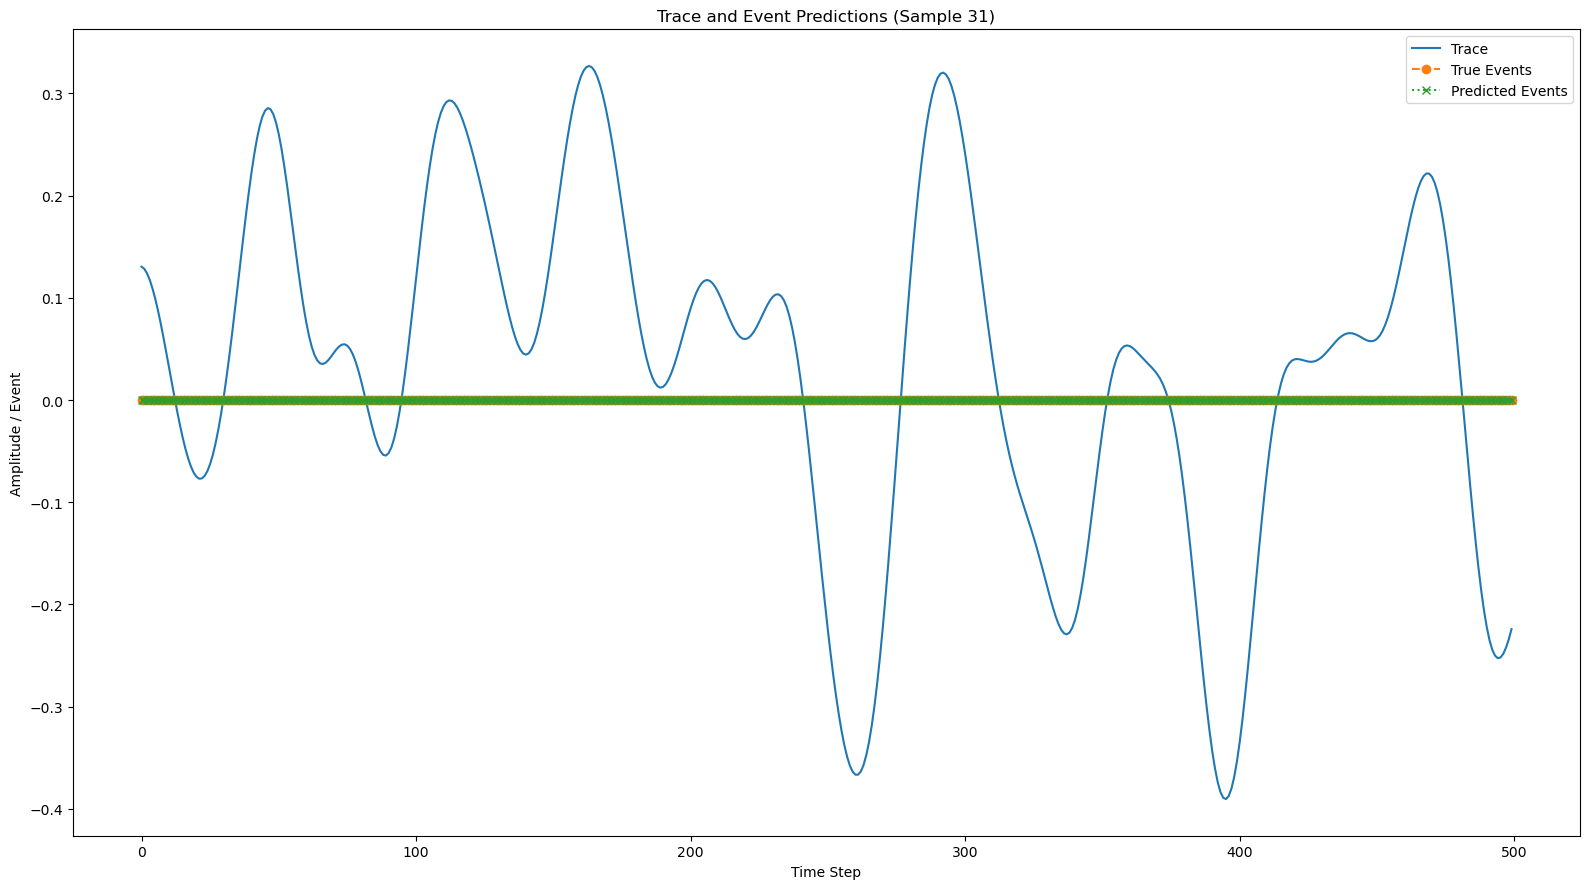

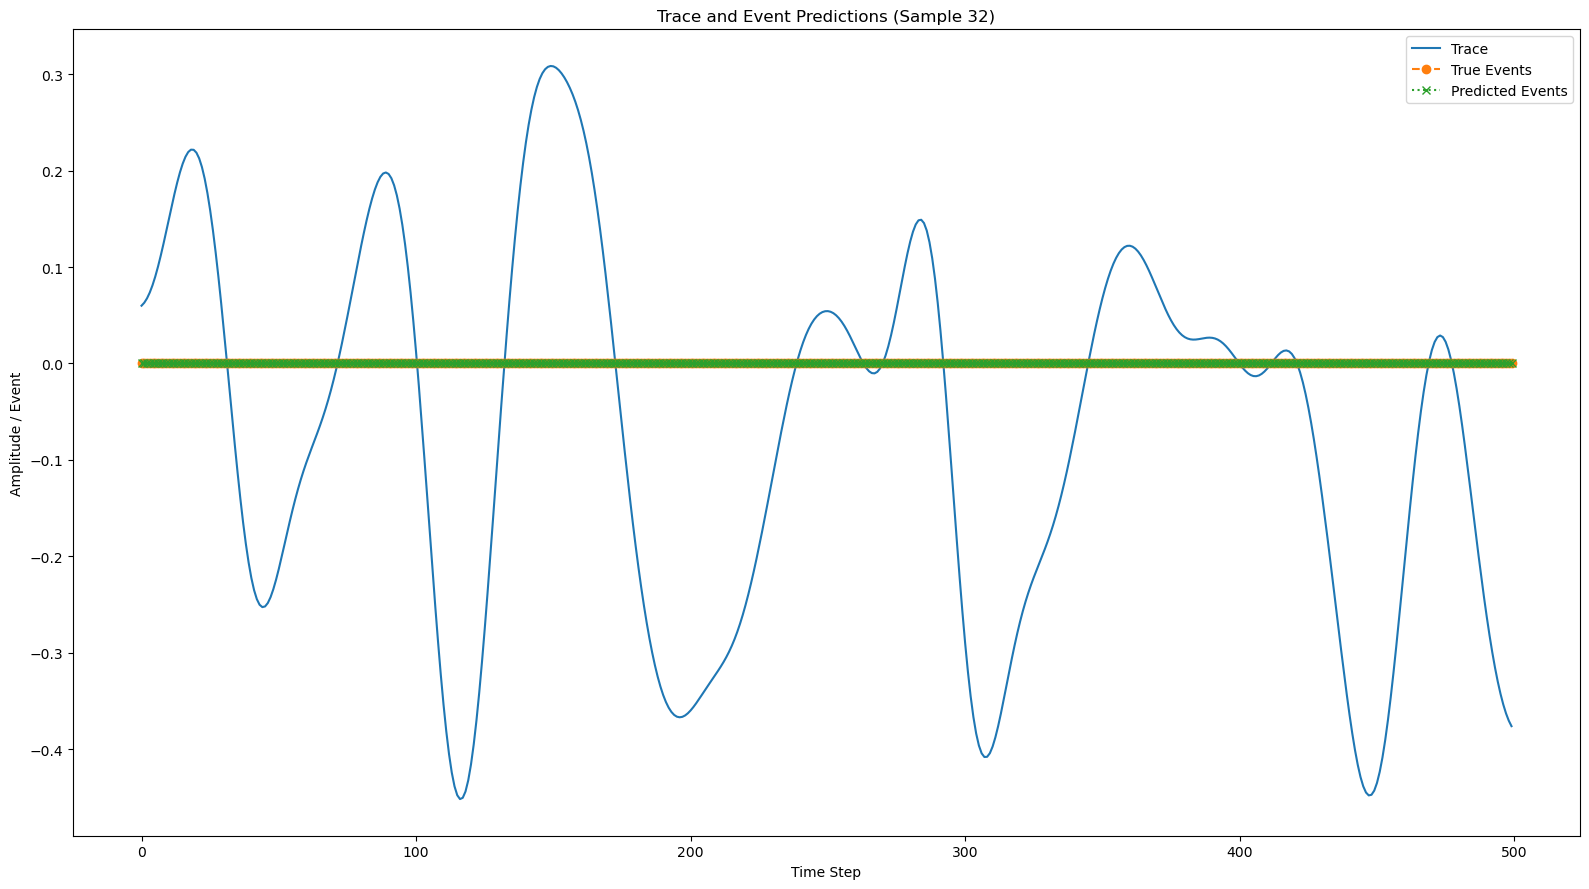

In [34]:
def visualize_predictions(model, data_loader, device, num_samples=1):
    """Visualizes predictions of the model on sample data."""
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            if i >= num_samples:
                break  # Stop after visualizing num_samples

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #outputs = model(inputs.permute(0,2,1))
            threshold = 0.49 # Example: Lower threshold
            probabilities = torch.softmax(outputs, dim=2) #Softmax to get probabilities
            predicted = (probabilities[:, :, 1] > threshold).long()
            #_, predicted = torch.max(outputs.data, 2)

            inputs_cpu = inputs.cpu().numpy()
            labels_cpu = labels.cpu().numpy()
            predicted_cpu = predicted.cpu().numpy()

            batch_size = inputs.shape[0]
            seq_len = inputs.shape[1]
            for j in range(batch_size):  # Iterate over batch
                plt.figure(figsize=(16,9))  # Adjust figure size as needed
                time = np.arange(seq_len)
                plt.plot(time, inputs_cpu[j, :, 0], label="Trace")  # Plot the trace
                plt.plot(time, labels_cpu[j, :], label="True Events", linestyle="--", marker='o')  # Plot true labels
                plt.plot(time, predicted_cpu[j, :], label="Predicted Events", linestyle=":", marker='x')  # Plot predicted labels
                plt.xlabel("Time Step")
                plt.ylabel("Amplitude / Event")
                plt.title(f"Trace and Event Predictions (Sample {i*batch_size + j + 1})")
                plt.legend()
                plt.tight_layout()
                plt.savefig(f'results/{j}.png',dpi=400)
                plt.show()
            break

\
visualize_predictions(model, test_loader, device, num_samples=1)

